In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Reshape, Flatten, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load the MNIST dataset
(X_train, _), (_, _) = mnist.load_data()

# Normalize the data
X_train = (X_train - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=-1)

# Parameters
img_rows, img_cols, channels = X_train.shape[1:]
img_shape = (img_rows, img_cols, channels)
latent_dim = 100


11490434/11490434 [==============================] - 25s 2us/step


In [2]:
def build_generator():
    model = Sequential()

    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    return model

generator = build_generator()
generator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                      

In [3]:
def build_discriminator():
    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))

    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               401920    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533505 (2.04 MB)
Trainable params: 53350

In [4]:
# Compile the Discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# The Generator takes noise as input and generates images
z = tf.keras.Input(shape=(latent_dim,))
img = generator(z)

# For the combined model, we will only train the Generator
discriminator.trainable = False

# The Discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model (stacked Generator and Discriminator)
combined = tf.keras.Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [9]:
import os

def save_imgs(epoch, save_dir=r"D:\combine dataset\aigen"):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * gen_imgs + 0.5

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig(os.path.join(save_dir, f"mnist_{epoch}.png"))
    plt.close()

# Train the GAN
train(epochs=10000, batch_size=64, save_interval=200)


2/2 [==============================] - 0s 18ms/step
0 [D loss: 0.319015733897686, acc.: 82.81%] [G loss: 0.7563012838363647]
2/2 [==============================] - 0s 16ms/step
1 [D loss: 0.28771371953189373, acc.: 91.41%] [G loss: 0.8887977600097656]
2/2 [==============================] - 0s 0s/step
2 [D loss: 0.2678285939618945, acc.: 95.31%] [G loss: 1.0371216535568237]
2/2 [==============================] - 0s 0s/step
3 [D loss: 0.2224593092687428, acc.: 98.44%] [G loss: 1.1765785217285156]
2/2 [==============================] - 0s 0s/step
4 [D loss: 0.19655604008585215, acc.: 99.22%] [G loss: 1.3898426294326782]
2/2 [==============================] - 0s 0s/step
5 [D loss: 0.1711511891335249, acc.: 100.00%] [G loss: 1.5308372974395752]
2/2 [==============================] - 0s 0s/step
6 [D loss: 0.13697567488998175, acc.: 100.00%] [G loss: 1.7382872104644775]
2/2 [==============================] - 0s 18ms/step
7 [D loss: 0.12201252719387412, acc.: 100.00%] [G loss: 1.86225938796997

2/2 [==============================] - 0s 5ms/step
64 [D loss: 0.00883316935505718, acc.: 100.00%] [G loss: 4.389344692230225]
2/2 [==============================] - 0s 4ms/step
65 [D loss: 0.013517288607545197, acc.: 100.00%] [G loss: 4.403410911560059]
2/2 [==============================] - 0s 13ms/step
66 [D loss: 0.010319591499865055, acc.: 100.00%] [G loss: 4.48519229888916]
2/2 [==============================] - 0s 16ms/step
67 [D loss: 0.009982624091207981, acc.: 100.00%] [G loss: 4.45175838470459]
2/2 [==============================] - 0s 6ms/step
68 [D loss: 0.008376276819035411, acc.: 100.00%] [G loss: 4.440218925476074]
2/2 [==============================] - 0s 3ms/step
69 [D loss: 0.00772587361279875, acc.: 100.00%] [G loss: 4.46607780456543]
2/2 [==============================] - 0s 0s/step
70 [D loss: 0.012664893991313875, acc.: 100.00%] [G loss: 4.555853843688965]
2/2 [==============================] - 0s 21ms/step
71 [D loss: 0.011645911959931254, acc.: 100.00%] [G loss

2/2 [==============================] - 0s 18ms/step
128 [D loss: 0.007690981030464172, acc.: 100.00%] [G loss: 5.272943496704102]
2/2 [==============================] - 0s 0s/step
129 [D loss: 0.010762738180346787, acc.: 100.00%] [G loss: 5.1695051193237305]
2/2 [==============================] - 0s 4ms/step
130 [D loss: 0.00990155409090221, acc.: 100.00%] [G loss: 5.298158645629883]
2/2 [==============================] - 0s 4ms/step
131 [D loss: 0.008449896704405546, acc.: 100.00%] [G loss: 5.281442642211914]
2/2 [==============================] - 0s 6ms/step
132 [D loss: 0.010423501953482628, acc.: 100.00%] [G loss: 5.113170623779297]
2/2 [==============================] - 0s 6ms/step
133 [D loss: 0.012998177204281092, acc.: 100.00%] [G loss: 5.128767967224121]
2/2 [==============================] - 0s 4ms/step
134 [D loss: 0.008437581127509475, acc.: 100.00%] [G loss: 5.284720420837402]
2/2 [==============================] - 0s 0s/step
135 [D loss: 0.01473469682969153, acc.: 100.00%

2/2 [==============================] - 0s 0s/step
192 [D loss: 0.09789809957146645, acc.: 97.66%] [G loss: 4.29446268081665]
2/2 [==============================] - 0s 5ms/step
193 [D loss: 0.8781911581754684, acc.: 67.97%] [G loss: 3.1293301582336426]
2/2 [==============================] - 0s 0s/step
194 [D loss: 0.17763708278653212, acc.: 89.06%] [G loss: 3.422849178314209]
2/2 [==============================] - 0s 3ms/step
195 [D loss: 0.07847807614598423, acc.: 96.88%] [G loss: 4.542763710021973]
2/2 [==============================] - 0s 18ms/step
196 [D loss: 0.07454221695661545, acc.: 98.44%] [G loss: 4.541740417480469]
2/2 [==============================] - 0s 5ms/step
197 [D loss: 0.13317745551466942, acc.: 94.53%] [G loss: 4.275449752807617]
2/2 [==============================] - 0s 7ms/step
198 [D loss: 0.17424343526363373, acc.: 93.75%] [G loss: 4.1141133308410645]
2/2 [==============================] - 0s 19ms/step
199 [D loss: 0.05789564549922943, acc.: 99.22%] [G loss: 4.4

2/2 [==============================] - 0s 18ms/step
256 [D loss: 0.12423160299658775, acc.: 98.44%] [G loss: 3.3202385902404785]
2/2 [==============================] - 0s 17ms/step
257 [D loss: 0.11069939285516739, acc.: 98.44%] [G loss: 3.035074472427368]
2/2 [==============================] - 0s 18ms/step
258 [D loss: 0.16054709255695343, acc.: 96.88%] [G loss: 3.451005458831787]
2/2 [==============================] - 0s 5ms/step
259 [D loss: 0.2589457258582115, acc.: 91.41%] [G loss: 3.1905765533447266]
2/2 [==============================] - 0s 8ms/step
260 [D loss: 0.29581376910209656, acc.: 87.50%] [G loss: 3.3420803546905518]
2/2 [==============================] - 0s 5ms/step
261 [D loss: 0.1841004155576229, acc.: 95.31%] [G loss: 3.518184185028076]
2/2 [==============================] - 0s 18ms/step
262 [D loss: 0.4912874847650528, acc.: 78.12%] [G loss: 2.282158374786377]
2/2 [==============================] - 0s 4ms/step
263 [D loss: 0.13775829784572124, acc.: 96.88%] [G loss:

2/2 [==============================] - 0s 0s/step
321 [D loss: 0.25088121369481087, acc.: 87.50%] [G loss: 3.334996461868286]
2/2 [==============================] - 0s 0s/step
322 [D loss: 0.45476149022579193, acc.: 78.91%] [G loss: 1.823870062828064]
2/2 [==============================] - 0s 0s/step
323 [D loss: 0.1930003985762596, acc.: 96.88%] [G loss: 2.8531343936920166]
2/2 [==============================] - 0s 0s/step
324 [D loss: 0.5502100586891174, acc.: 64.84%] [G loss: 2.399261713027954]
2/2 [==============================] - 0s 0s/step
325 [D loss: 0.23737618327140808, acc.: 96.09%] [G loss: 3.6101279258728027]
2/2 [==============================] - 0s 16ms/step
326 [D loss: 1.010166585445404, acc.: 46.88%] [G loss: 0.9711917638778687]
2/2 [==============================] - 0s 0s/step
327 [D loss: 0.5226064249873161, acc.: 62.50%] [G loss: 2.2279162406921387]
2/2 [==============================] - 0s 0s/step
328 [D loss: 0.18441557884216309, acc.: 96.09%] [G loss: 3.38666200

2/2 [==============================] - 0s 0s/step
386 [D loss: 0.666401669383049, acc.: 51.56%] [G loss: 0.8652563095092773]
2/2 [==============================] - 0s 0s/step
387 [D loss: 0.7089173793792725, acc.: 40.62%] [G loss: 0.7362149357795715]
2/2 [==============================] - 0s 0s/step
388 [D loss: 0.6812029778957367, acc.: 47.66%] [G loss: 0.785539984703064]
2/2 [==============================] - 0s 0s/step
389 [D loss: 0.6753296852111816, acc.: 49.22%] [G loss: 0.7707957029342651]
2/2 [==============================] - 0s 16ms/step
390 [D loss: 0.6619207262992859, acc.: 48.44%] [G loss: 0.7833021283149719]
2/2 [==============================] - 0s 0s/step
391 [D loss: 0.681768149137497, acc.: 43.75%] [G loss: 0.7878408432006836]
2/2 [==============================] - 0s 0s/step
392 [D loss: 0.7282008230686188, acc.: 42.19%] [G loss: 0.7491869926452637]
2/2 [==============================] - 0s 0s/step
393 [D loss: 0.6315748393535614, acc.: 50.00%] [G loss: 0.81284463405

2/2 [==============================] - 0s 0s/step
451 [D loss: 0.6307471692562103, acc.: 46.88%] [G loss: 0.6586483716964722]
2/2 [==============================] - 0s 0s/step
452 [D loss: 0.6466259062290192, acc.: 48.44%] [G loss: 0.672966480255127]
2/2 [==============================] - 0s 0s/step
453 [D loss: 0.6855739653110504, acc.: 41.41%] [G loss: 0.6613137125968933]
2/2 [==============================] - 0s 0s/step
454 [D loss: 0.6797814965248108, acc.: 38.28%] [G loss: 0.6528854370117188]
2/2 [==============================] - 0s 17ms/step
455 [D loss: 0.6533912420272827, acc.: 46.09%] [G loss: 0.6632540225982666]
2/2 [==============================] - 0s 0s/step
456 [D loss: 0.6713049411773682, acc.: 44.53%] [G loss: 0.6692364811897278]
2/2 [==============================] - 0s 0s/step
457 [D loss: 0.6629545092582703, acc.: 44.53%] [G loss: 0.6777466535568237]
2/2 [==============================] - 0s 0s/step
458 [D loss: 0.6414151787757874, acc.: 46.88%] [G loss: 0.677889585

2/2 [==============================] - 0s 10ms/step
516 [D loss: 0.6200584918260574, acc.: 50.78%] [G loss: 0.6708277463912964]
2/2 [==============================] - 0s 15ms/step
517 [D loss: 0.648040771484375, acc.: 46.88%] [G loss: 0.686388373374939]
2/2 [==============================] - 0s 7ms/step
518 [D loss: 0.6416908800601959, acc.: 52.34%] [G loss: 0.6764689683914185]
2/2 [==============================] - 0s 4ms/step
519 [D loss: 0.625962883234024, acc.: 54.69%] [G loss: 0.6962224245071411]
2/2 [==============================] - 0s 8ms/step
520 [D loss: 0.6263904273509979, acc.: 57.81%] [G loss: 0.7010154128074646]
2/2 [==============================] - 0s 13ms/step
521 [D loss: 0.634921669960022, acc.: 60.16%] [G loss: 0.7043024301528931]
2/2 [==============================] - 0s 10ms/step
522 [D loss: 0.6348003447055817, acc.: 52.34%] [G loss: 0.7274037599563599]
2/2 [==============================] - 0s 4ms/step
523 [D loss: 0.6327497065067291, acc.: 53.12%] [G loss: 0.73

2/2 [==============================] - 0s 17ms/step
581 [D loss: 0.6004592478275299, acc.: 71.88%] [G loss: 0.748843789100647]
2/2 [==============================] - 0s 0s/step
582 [D loss: 0.6120024621486664, acc.: 65.62%] [G loss: 0.7527536749839783]
2/2 [==============================] - 0s 0s/step
583 [D loss: 0.6130464226007462, acc.: 65.62%] [G loss: 0.7436719536781311]
2/2 [==============================] - 0s 14ms/step
584 [D loss: 0.5959564745426178, acc.: 69.53%] [G loss: 0.7447704076766968]
2/2 [==============================] - 0s 0s/step
585 [D loss: 0.608637735247612, acc.: 72.66%] [G loss: 0.7450556755065918]
2/2 [==============================] - 0s 5ms/step
586 [D loss: 0.6037214994430542, acc.: 69.53%] [G loss: 0.7461020946502686]
2/2 [==============================] - 0s 18ms/step
587 [D loss: 0.5958186089992523, acc.: 64.84%] [G loss: 0.7380987405776978]
2/2 [==============================] - 0s 0s/step
588 [D loss: 0.5966836661100388, acc.: 68.75%] [G loss: 0.74146

2/2 [==============================] - 0s 0s/step
645 [D loss: 0.6036023646593094, acc.: 63.28%] [G loss: 0.7912032604217529]
2/2 [==============================] - 0s 0s/step
646 [D loss: 0.6143656075000763, acc.: 59.38%] [G loss: 0.8250012397766113]
2/2 [==============================] - 0s 0s/step
647 [D loss: 0.5965354144573212, acc.: 73.44%] [G loss: 0.8308016061782837]
2/2 [==============================] - 0s 0s/step
648 [D loss: 0.6141645312309265, acc.: 67.19%] [G loss: 0.8195095658302307]
2/2 [==============================] - 0s 0s/step
649 [D loss: 0.6082304567098618, acc.: 67.97%] [G loss: 0.8046582937240601]
2/2 [==============================] - 0s 0s/step
650 [D loss: 0.5999175012111664, acc.: 73.44%] [G loss: 0.793489933013916]
2/2 [==============================] - 0s 0s/step
651 [D loss: 0.60198575258255, acc.: 72.66%] [G loss: 0.7906668186187744]
2/2 [==============================] - 0s 0s/step
652 [D loss: 0.595834344625473, acc.: 72.66%] [G loss: 0.77129161357879

2/2 [==============================] - 0s 0s/step
710 [D loss: 0.6136482656002045, acc.: 67.97%] [G loss: 0.7943747639656067]
2/2 [==============================] - 0s 0s/step
711 [D loss: 0.5940324515104294, acc.: 70.31%] [G loss: 0.8058958053588867]
2/2 [==============================] - 0s 16ms/step
712 [D loss: 0.5883709490299225, acc.: 69.53%] [G loss: 0.8017617464065552]
2/2 [==============================] - 0s 0s/step
713 [D loss: 0.5916550010442734, acc.: 66.41%] [G loss: 0.7820107936859131]
2/2 [==============================] - 0s 0s/step
714 [D loss: 0.5704340636730194, acc.: 68.75%] [G loss: 0.819549560546875]
2/2 [==============================] - 0s 0s/step
715 [D loss: 0.583346039056778, acc.: 73.44%] [G loss: 0.8473299145698547]
2/2 [==============================] - 0s 16ms/step
716 [D loss: 0.5912921726703644, acc.: 71.88%] [G loss: 0.8582468032836914]
2/2 [==============================] - 0s 0s/step
717 [D loss: 0.5842336267232895, acc.: 74.22%] [G loss: 0.82374322

2/2 [==============================] - 0s 0s/step
775 [D loss: 0.6395528614521027, acc.: 61.72%] [G loss: 0.815481424331665]
2/2 [==============================] - 0s 0s/step
776 [D loss: 0.6314089000225067, acc.: 67.19%] [G loss: 0.8576879501342773]
2/2 [==============================] - 0s 0s/step
777 [D loss: 0.6120018362998962, acc.: 67.97%] [G loss: 0.8457367420196533]
2/2 [==============================] - 0s 0s/step
778 [D loss: 0.6472567319869995, acc.: 59.38%] [G loss: 0.8495007157325745]
2/2 [==============================] - 0s 0s/step
779 [D loss: 0.63371342420578, acc.: 58.59%] [G loss: 0.8551594018936157]
2/2 [==============================] - 0s 0s/step
780 [D loss: 0.657138466835022, acc.: 56.25%] [G loss: 0.8139590620994568]
2/2 [==============================] - 0s 0s/step
781 [D loss: 0.631453663110733, acc.: 61.72%] [G loss: 0.8067052960395813]
2/2 [==============================] - 0s 0s/step
782 [D loss: 0.6616605818271637, acc.: 52.34%] [G loss: 0.794598698616027

2/2 [==============================] - 0s 0s/step
840 [D loss: 0.5791450142860413, acc.: 77.34%] [G loss: 0.8273754119873047]
2/2 [==============================] - 0s 16ms/step
841 [D loss: 0.582857757806778, acc.: 78.12%] [G loss: 0.8360925912857056]
2/2 [==============================] - 0s 16ms/step
842 [D loss: 0.621103048324585, acc.: 66.41%] [G loss: 0.8320798873901367]
2/2 [==============================] - 0s 0s/step
843 [D loss: 0.6272013783454895, acc.: 65.62%] [G loss: 0.8381316065788269]
2/2 [==============================] - 0s 0s/step
844 [D loss: 0.6269659996032715, acc.: 70.31%] [G loss: 0.8187507390975952]
2/2 [==============================] - 0s 0s/step
845 [D loss: 0.6356356143951416, acc.: 62.50%] [G loss: 0.8056631684303284]
2/2 [==============================] - 0s 0s/step
846 [D loss: 0.594651073217392, acc.: 73.44%] [G loss: 0.8268241882324219]
2/2 [==============================] - 0s 16ms/step
847 [D loss: 0.6295690536499023, acc.: 64.84%] [G loss: 0.8492512

2/2 [==============================] - 0s 0s/step
905 [D loss: 0.6066237390041351, acc.: 65.62%] [G loss: 0.8193790912628174]
2/2 [==============================] - 0s 0s/step
906 [D loss: 0.6003666073083878, acc.: 64.84%] [G loss: 0.8712515830993652]
2/2 [==============================] - 0s 1ms/step
907 [D loss: 0.5904524326324463, acc.: 67.97%] [G loss: 0.8774887323379517]
2/2 [==============================] - 0s 0s/step
908 [D loss: 0.5789290368556976, acc.: 72.66%] [G loss: 0.9260276556015015]
2/2 [==============================] - 0s 16ms/step
909 [D loss: 0.616788774728775, acc.: 67.97%] [G loss: 0.9473165273666382]
2/2 [==============================] - 0s 0s/step
910 [D loss: 0.6266544759273529, acc.: 67.97%] [G loss: 0.8852997422218323]
2/2 [==============================] - 0s 0s/step
911 [D loss: 0.6080498099327087, acc.: 71.88%] [G loss: 0.8763977289199829]
2/2 [==============================] - 0s 16ms/step
912 [D loss: 0.5897878408432007, acc.: 69.53%] [G loss: 0.835352

2/2 [==============================] - 0s 0s/step
970 [D loss: 0.5715093165636063, acc.: 73.44%] [G loss: 0.9521961212158203]
2/2 [==============================] - 0s 0s/step
971 [D loss: 0.6006183326244354, acc.: 66.41%] [G loss: 0.9299682974815369]
2/2 [==============================] - 0s 0s/step
972 [D loss: 0.614427775144577, acc.: 65.62%] [G loss: 0.9201786518096924]
2/2 [==============================] - 0s 0s/step
973 [D loss: 0.5855709910392761, acc.: 73.44%] [G loss: 0.9054524898529053]
2/2 [==============================] - 0s 16ms/step
974 [D loss: 0.5584373474121094, acc.: 75.00%] [G loss: 0.8823187947273254]
2/2 [==============================] - 0s 16ms/step
975 [D loss: 0.5969212055206299, acc.: 72.66%] [G loss: 0.8924859762191772]
2/2 [==============================] - 0s 0s/step
976 [D loss: 0.5694165229797363, acc.: 75.00%] [G loss: 0.9152367115020752]
2/2 [==============================] - 0s 0s/step
977 [D loss: 0.5495069772005081, acc.: 76.56%] [G loss: 0.9661412

2/2 [==============================] - 0s 0s/step
1034 [D loss: 0.5795524418354034, acc.: 67.97%] [G loss: 0.9417234659194946]
2/2 [==============================] - 0s 0s/step
1035 [D loss: 0.5665333420038223, acc.: 77.34%] [G loss: 0.9439289569854736]
2/2 [==============================] - 0s 0s/step
1036 [D loss: 0.5662713646888733, acc.: 77.34%] [G loss: 0.9761769771575928]
2/2 [==============================] - 0s 0s/step
1037 [D loss: 0.5758270621299744, acc.: 73.44%] [G loss: 0.9337341785430908]
2/2 [==============================] - 0s 0s/step
1038 [D loss: 0.6051459610462189, acc.: 72.66%] [G loss: 0.9220010042190552]
2/2 [==============================] - 0s 0s/step
1039 [D loss: 0.527212992310524, acc.: 85.16%] [G loss: 0.9125504493713379]
2/2 [==============================] - 0s 0s/step
1040 [D loss: 0.5617946088314056, acc.: 74.22%] [G loss: 0.9262394905090332]
2/2 [==============================] - 0s 0s/step
1041 [D loss: 0.5335175395011902, acc.: 80.47%] [G loss: 0.994

1098 [D loss: 0.5596936345100403, acc.: 68.75%] [G loss: 0.9272279739379883]
2/2 [==============================] - 0s 0s/step
1099 [D loss: 0.5565611124038696, acc.: 75.00%] [G loss: 0.9961297512054443]
2/2 [==============================] - 0s 0s/step
1100 [D loss: 0.5518684089183807, acc.: 75.78%] [G loss: 0.9860969185829163]
2/2 [==============================] - 0s 16ms/step
1101 [D loss: 0.5419433563947678, acc.: 76.56%] [G loss: 0.9994838237762451]
2/2 [==============================] - 0s 0s/step
1102 [D loss: 0.5852434635162354, acc.: 69.53%] [G loss: 1.0320360660552979]
2/2 [==============================] - 0s 16ms/step
1103 [D loss: 0.5266491174697876, acc.: 84.38%] [G loss: 1.000422716140747]
2/2 [==============================] - 0s 2ms/step
1104 [D loss: 0.5804884731769562, acc.: 74.22%] [G loss: 0.9382370114326477]
2/2 [==============================] - 0s 7ms/step
1105 [D loss: 0.5981046259403229, acc.: 67.19%] [G loss: 0.9760909080505371]
2/2 [========================

2/2 [==============================] - 0s 0s/step
1163 [D loss: 0.5153025984764099, acc.: 78.12%] [G loss: 1.0545103549957275]
2/2 [==============================] - 0s 14ms/step
1164 [D loss: 0.5349486470222473, acc.: 82.81%] [G loss: 1.0435950756072998]
2/2 [==============================] - 0s 0s/step
1165 [D loss: 0.5240245312452316, acc.: 82.03%] [G loss: 1.016257405281067]
2/2 [==============================] - 0s 0s/step
1166 [D loss: 0.5368144363164902, acc.: 77.34%] [G loss: 0.9705261588096619]
2/2 [==============================] - 0s 17ms/step
1167 [D loss: 0.5827026069164276, acc.: 68.75%] [G loss: 0.98762047290802]
2/2 [==============================] - 0s 0s/step
1168 [D loss: 0.504597395658493, acc.: 82.81%] [G loss: 1.0598220825195312]
2/2 [==============================] - 0s 0s/step
1169 [D loss: 0.5450721383094788, acc.: 80.47%] [G loss: 1.0012463331222534]
2/2 [==============================] - 0s 17ms/step
1170 [D loss: 0.5458605587482452, acc.: 78.12%] [G loss: 0.

2/2 [==============================] - 0s 17ms/step
1227 [D loss: 0.5100340843200684, acc.: 86.72%] [G loss: 0.9330790042877197]
2/2 [==============================] - 0s 18ms/step
1228 [D loss: 0.5783272087574005, acc.: 73.44%] [G loss: 0.9450861811637878]
2/2 [==============================] - 0s 19ms/step
1229 [D loss: 0.5486475825309753, acc.: 75.00%] [G loss: 0.9810700416564941]
2/2 [==============================] - 0s 6ms/step
1230 [D loss: 0.5298251211643219, acc.: 80.47%] [G loss: 1.0199668407440186]
2/2 [==============================] - 0s 6ms/step
1231 [D loss: 0.5289768576622009, acc.: 79.69%] [G loss: 1.001357078552246]
2/2 [==============================] - 0s 7ms/step
1232 [D loss: 0.51221564412117, acc.: 83.59%] [G loss: 1.0121389627456665]
2/2 [==============================] - 0s 10ms/step
1233 [D loss: 0.5386385321617126, acc.: 82.03%] [G loss: 1.0022389888763428]
2/2 [==============================] - 0s 4ms/step
1234 [D loss: 0.5505488067865372, acc.: 78.12%] [G l

2/2 [==============================] - 0s 946us/step
1291 [D loss: 0.5544757843017578, acc.: 73.44%] [G loss: 1.0165300369262695]
2/2 [==============================] - 0s 0s/step
1292 [D loss: 0.5078943371772766, acc.: 85.16%] [G loss: 1.051917552947998]
2/2 [==============================] - 0s 4ms/step
1293 [D loss: 0.5308509767055511, acc.: 82.03%] [G loss: 1.0036537647247314]
2/2 [==============================] - 0s 5ms/step
1294 [D loss: 0.5255354642868042, acc.: 78.91%] [G loss: 1.0687000751495361]
2/2 [==============================] - 0s 7ms/step
1295 [D loss: 0.5633606314659119, acc.: 73.44%] [G loss: 1.0705198049545288]
2/2 [==============================] - 0s 4ms/step
1296 [D loss: 0.5232794284820557, acc.: 76.56%] [G loss: 1.0538270473480225]
2/2 [==============================] - 0s 19ms/step
1297 [D loss: 0.5485775917768478, acc.: 68.75%] [G loss: 1.0677549839019775]
2/2 [==============================] - 0s 4ms/step
1298 [D loss: 0.5857358872890472, acc.: 69.53%] [G l

2/2 [==============================] - 0s 16ms/step
1355 [D loss: 0.5432871878147125, acc.: 76.56%] [G loss: 1.0796281099319458]
2/2 [==============================] - 0s 16ms/step
1356 [D loss: 0.5449613332748413, acc.: 77.34%] [G loss: 1.090323805809021]
2/2 [==============================] - 0s 16ms/step
1357 [D loss: 0.5474638938903809, acc.: 73.44%] [G loss: 1.029712438583374]
2/2 [==============================] - 0s 0s/step
1358 [D loss: 0.5614767372608185, acc.: 74.22%] [G loss: 1.0585567951202393]
2/2 [==============================] - 0s 16ms/step
1359 [D loss: 0.550520271062851, acc.: 78.91%] [G loss: 1.0951471328735352]
2/2 [==============================] - 0s 16ms/step
1360 [D loss: 0.48624536395072937, acc.: 86.72%] [G loss: 1.1113672256469727]
2/2 [==============================] - 0s 16ms/step
1361 [D loss: 0.5587915778160095, acc.: 75.78%] [G loss: 1.09319269657135]
2/2 [==============================] - 0s 16ms/step
1362 [D loss: 0.5006880462169647, acc.: 81.25%] [G 

2/2 [==============================] - 0s 0s/step
1419 [D loss: 0.5556729137897491, acc.: 74.22%] [G loss: 1.0240362882614136]
2/2 [==============================] - 0s 0s/step
1420 [D loss: 0.5263503193855286, acc.: 78.12%] [G loss: 1.0994420051574707]
2/2 [==============================] - 0s 0s/step
1421 [D loss: 0.5758271217346191, acc.: 74.22%] [G loss: 1.0701990127563477]
2/2 [==============================] - 0s 16ms/step
1422 [D loss: 0.5547598898410797, acc.: 71.09%] [G loss: 1.057356595993042]
2/2 [==============================] - 0s 0s/step
1423 [D loss: 0.5429427921772003, acc.: 75.00%] [G loss: 1.0641379356384277]
2/2 [==============================] - 0s 16ms/step
1424 [D loss: 0.5254608690738678, acc.: 78.12%] [G loss: 1.0960712432861328]
2/2 [==============================] - 0s 0s/step
1425 [D loss: 0.5851050615310669, acc.: 67.19%] [G loss: 1.1180288791656494]
2/2 [==============================] - 0s 16ms/step
1426 [D loss: 0.5650151968002319, acc.: 71.88%] [G loss:

2/2 [==============================] - 0s 0s/step
1484 [D loss: 0.503479927778244, acc.: 81.25%] [G loss: 1.0465900897979736]
2/2 [==============================] - 0s 0s/step
1485 [D loss: 0.5526599884033203, acc.: 75.78%] [G loss: 1.0321723222732544]
2/2 [==============================] - 0s 0s/step
1486 [D loss: 0.5414858758449554, acc.: 70.31%] [G loss: 1.0240355730056763]
2/2 [==============================] - 0s 0s/step
1487 [D loss: 0.5506904423236847, acc.: 73.44%] [G loss: 1.0132516622543335]
2/2 [==============================] - 0s 0s/step
1488 [D loss: 0.5035526752471924, acc.: 80.47%] [G loss: 1.0703353881835938]
2/2 [==============================] - 0s 0s/step
1489 [D loss: 0.5655119121074677, acc.: 78.12%] [G loss: 0.9861669540405273]
2/2 [==============================] - 0s 0s/step
1490 [D loss: 0.5594527125358582, acc.: 71.88%] [G loss: 1.006483793258667]
2/2 [==============================] - 0s 0s/step
1491 [D loss: 0.5629145205020905, acc.: 73.44%] [G loss: 1.0336

2/2 [==============================] - 0s 16ms/step
1549 [D loss: 0.5537016987800598, acc.: 72.66%] [G loss: 1.008099913597107]
2/2 [==============================] - 0s 0s/step
1550 [D loss: 0.5144018828868866, acc.: 75.78%] [G loss: 1.0405595302581787]
2/2 [==============================] - 0s 0s/step
1551 [D loss: 0.5275494754314423, acc.: 75.78%] [G loss: 1.0571032762527466]
2/2 [==============================] - 0s 16ms/step
1552 [D loss: 0.5437473356723785, acc.: 77.34%] [G loss: 1.037519097328186]
2/2 [==============================] - 0s 0s/step
1553 [D loss: 0.5649923086166382, acc.: 71.88%] [G loss: 1.0262012481689453]
2/2 [==============================] - 0s 16ms/step
1554 [D loss: 0.5294881463050842, acc.: 78.12%] [G loss: 1.075918436050415]
2/2 [==============================] - 0s 0s/step
1555 [D loss: 0.5619704127311707, acc.: 72.66%] [G loss: 1.0218225717544556]
2/2 [==============================] - 0s 0s/step
1556 [D loss: 0.5766055583953857, acc.: 72.66%] [G loss: 0

2/2 [==============================] - 0s 0s/step
1613 [D loss: 0.5487345308065414, acc.: 75.78%] [G loss: 1.0577890872955322]
2/2 [==============================] - 0s 0s/step
1614 [D loss: 0.5265102684497833, acc.: 80.47%] [G loss: 1.0862212181091309]
2/2 [==============================] - 0s 0s/step
1615 [D loss: 0.5133684575557709, acc.: 75.78%] [G loss: 1.0977061986923218]
2/2 [==============================] - 0s 0s/step
1616 [D loss: 0.5605655014514923, acc.: 71.88%] [G loss: 1.0858021974563599]
2/2 [==============================] - 0s 0s/step
1617 [D loss: 0.5902911126613617, acc.: 67.19%] [G loss: 1.025771141052246]
2/2 [==============================] - 0s 0s/step
1618 [D loss: 0.6024543642997742, acc.: 63.28%] [G loss: 1.0128237009048462]
2/2 [==============================] - 0s 0s/step
1619 [D loss: 0.5519885420799255, acc.: 75.78%] [G loss: 1.013667106628418]
2/2 [==============================] - 0s 0s/step
1620 [D loss: 0.5504420399665833, acc.: 71.09%] [G loss: 1.0467

2/2 [==============================] - 0s 16ms/step
1678 [D loss: 0.5514064729213715, acc.: 78.12%] [G loss: 1.03632652759552]
2/2 [==============================] - 0s 16ms/step
1679 [D loss: 0.5158744007349014, acc.: 79.69%] [G loss: 1.0311002731323242]
2/2 [==============================] - 0s 0s/step
1680 [D loss: 0.5414215922355652, acc.: 78.12%] [G loss: 1.0087485313415527]
2/2 [==============================] - 0s 16ms/step
1681 [D loss: 0.5367026925086975, acc.: 74.22%] [G loss: 1.0961295366287231]
2/2 [==============================] - 0s 16ms/step
1682 [D loss: 0.4894178956747055, acc.: 78.12%] [G loss: 1.0960980653762817]
2/2 [==============================] - 0s 0s/step
1683 [D loss: 0.5321827530860901, acc.: 75.78%] [G loss: 1.0078898668289185]
2/2 [==============================] - 0s 0s/step
1684 [D loss: 0.5926317572593689, acc.: 69.53%] [G loss: 1.0214099884033203]
2/2 [==============================] - 0s 0s/step
1685 [D loss: 0.5343523919582367, acc.: 80.47%] [G loss

2/2 [==============================] - 0s 0s/step
1742 [D loss: 0.5381468832492828, acc.: 77.34%] [G loss: 1.047609806060791]
2/2 [==============================] - 0s 16ms/step
1743 [D loss: 0.500858336687088, acc.: 80.47%] [G loss: 1.0968332290649414]
2/2 [==============================] - 0s 0s/step
1744 [D loss: 0.5378513932228088, acc.: 76.56%] [G loss: 1.1029260158538818]
2/2 [==============================] - 0s 0s/step
1745 [D loss: 0.5845455527305603, acc.: 73.44%] [G loss: 0.9540652632713318]
2/2 [==============================] - 0s 0s/step
1746 [D loss: 0.5511892437934875, acc.: 74.22%] [G loss: 0.988733172416687]
2/2 [==============================] - 0s 0s/step
1747 [D loss: 0.5537730157375336, acc.: 72.66%] [G loss: 1.0472486019134521]
2/2 [==============================] - 0s 0s/step
1748 [D loss: 0.49741916358470917, acc.: 86.72%] [G loss: 1.0504932403564453]
2/2 [==============================] - 0s 16ms/step
1749 [D loss: 0.4955465495586395, acc.: 82.03%] [G loss: 1.

2/2 [==============================] - 0s 0s/step
1806 [D loss: 0.5789472460746765, acc.: 73.44%] [G loss: 1.0361411571502686]
2/2 [==============================] - 0s 18ms/step
1807 [D loss: 0.5701943039894104, acc.: 70.31%] [G loss: 1.015002965927124]
2/2 [==============================] - 0s 17ms/step
1808 [D loss: 0.5443267524242401, acc.: 81.25%] [G loss: 1.0215864181518555]
2/2 [==============================] - 0s 0s/step
1809 [D loss: 0.5658216774463654, acc.: 78.12%] [G loss: 1.0078060626983643]
2/2 [==============================] - 0s 12ms/step
1810 [D loss: 0.5258978307247162, acc.: 78.91%] [G loss: 0.9826477766036987]
2/2 [==============================] - 0s 8ms/step
1811 [D loss: 0.5543903112411499, acc.: 72.66%] [G loss: 1.0511479377746582]
2/2 [==============================] - 0s 0s/step
1812 [D loss: 0.5157834142446518, acc.: 79.69%] [G loss: 1.042013168334961]
2/2 [==============================] - 0s 8ms/step
1813 [D loss: 0.5655814409255981, acc.: 71.09%] [G loss

2/2 [==============================] - 0s 0s/step
1870 [D loss: 0.5356326401233673, acc.: 73.44%] [G loss: 1.0414470434188843]
2/2 [==============================] - 0s 0s/step
1871 [D loss: 0.5693423748016357, acc.: 71.09%] [G loss: 1.05961275100708]
2/2 [==============================] - 0s 11ms/step
1872 [D loss: 0.53023561835289, acc.: 76.56%] [G loss: 1.091050386428833]
2/2 [==============================] - 0s 0s/step
1873 [D loss: 0.5223638713359833, acc.: 78.91%] [G loss: 1.021700382232666]
2/2 [==============================] - 0s 8ms/step
1874 [D loss: 0.5550758540630341, acc.: 71.88%] [G loss: 0.9988148212432861]
2/2 [==============================] - 0s 8ms/step
1875 [D loss: 0.5361688435077667, acc.: 72.66%] [G loss: 1.0838931798934937]
2/2 [==============================] - 0s 7ms/step
1876 [D loss: 0.5515093207359314, acc.: 72.66%] [G loss: 1.0935113430023193]
2/2 [==============================] - 0s 8ms/step
1877 [D loss: 0.5091307461261749, acc.: 74.22%] [G loss: 1.03

2/2 [==============================] - 0s 8ms/step
1934 [D loss: 0.6117490828037262, acc.: 64.06%] [G loss: 1.0081231594085693]
2/2 [==============================] - 0s 8ms/step
1935 [D loss: 0.5433515310287476, acc.: 78.12%] [G loss: 0.9608012437820435]
2/2 [==============================] - 0s 8ms/step
1936 [D loss: 0.5464691817760468, acc.: 76.56%] [G loss: 1.092674970626831]
2/2 [==============================] - 0s 0s/step
1937 [D loss: 0.5398440212011337, acc.: 76.56%] [G loss: 1.0622272491455078]
2/2 [==============================] - 0s 8ms/step
1938 [D loss: 0.5335724055767059, acc.: 80.47%] [G loss: 1.0430748462677002]
2/2 [==============================] - 0s 0s/step
1939 [D loss: 0.5318815410137177, acc.: 80.47%] [G loss: 1.034778356552124]
2/2 [==============================] - 0s 8ms/step
1940 [D loss: 0.5318566262722015, acc.: 82.81%] [G loss: 1.0547157526016235]
2/2 [==============================] - 0s 0s/step
1941 [D loss: 0.5108565539121628, acc.: 79.69%] [G loss: 1

2/2 [==============================] - 0s 10ms/step
1998 [D loss: 0.573040246963501, acc.: 68.75%] [G loss: 1.068006992340088]
2/2 [==============================] - 0s 14ms/step
1999 [D loss: 0.5250697731971741, acc.: 80.47%] [G loss: 1.0620629787445068]
2/2 [==============================] - 0s 8ms/step
2000 [D loss: 0.5461778938770294, acc.: 71.88%] [G loss: 1.0720667839050293]
2/2 [==============================] - 0s 7ms/step
2001 [D loss: 0.5692847073078156, acc.: 70.31%] [G loss: 1.043747901916504]
2/2 [==============================] - 0s 9ms/step
2002 [D loss: 0.5043038725852966, acc.: 80.47%] [G loss: 1.1057658195495605]
2/2 [==============================] - 0s 10ms/step
2003 [D loss: 0.5498029291629791, acc.: 75.00%] [G loss: 1.102474331855774]
2/2 [==============================] - 0s 9ms/step
2004 [D loss: 0.5460236072540283, acc.: 70.31%] [G loss: 1.0214338302612305]
2/2 [==============================] - 0s 9ms/step
2005 [D loss: 0.5466118454933167, acc.: 78.12%] [G los

2/2 [==============================] - 0s 16ms/step
2062 [D loss: 0.5569605529308319, acc.: 75.00%] [G loss: 1.0302228927612305]
2/2 [==============================] - 0s 0s/step
2063 [D loss: 0.5622706413269043, acc.: 75.00%] [G loss: 1.0716943740844727]
2/2 [==============================] - 0s 42us/step
2064 [D loss: 0.5178179144859314, acc.: 78.91%] [G loss: 1.012787103652954]
2/2 [==============================] - 0s 0s/step
2065 [D loss: 0.5850439667701721, acc.: 70.31%] [G loss: 1.061044692993164]
2/2 [==============================] - 0s 6ms/step
2066 [D loss: 0.5509628653526306, acc.: 73.44%] [G loss: 1.0305476188659668]
2/2 [==============================] - 0s 0s/step
2067 [D loss: 0.5556369423866272, acc.: 75.78%] [G loss: 1.033752202987671]
2/2 [==============================] - 0s 8ms/step
2068 [D loss: 0.5622231960296631, acc.: 75.00%] [G loss: 1.0648350715637207]
2/2 [==============================] - 0s 8ms/step
2069 [D loss: 0.5463673919439316, acc.: 73.44%] [G loss: 

2/2 [==============================] - 0s 8ms/step
2126 [D loss: 0.5652874410152435, acc.: 74.22%] [G loss: 1.0188426971435547]
2/2 [==============================] - 0s 8ms/step
2127 [D loss: 0.5318051874637604, acc.: 75.78%] [G loss: 1.0992822647094727]
2/2 [==============================] - 0s 0s/step
2128 [D loss: 0.5767953097820282, acc.: 71.88%] [G loss: 1.014090895652771]
2/2 [==============================] - 0s 13ms/step
2129 [D loss: 0.559090256690979, acc.: 72.66%] [G loss: 1.0554218292236328]
2/2 [==============================] - 0s 0s/step
2130 [D loss: 0.6449567973613739, acc.: 60.16%] [G loss: 0.9861040115356445]
2/2 [==============================] - 0s 10ms/step
2131 [D loss: 0.518255740404129, acc.: 75.78%] [G loss: 1.014929175376892]
2/2 [==============================] - 0s 8ms/step
2132 [D loss: 0.5620990991592407, acc.: 74.22%] [G loss: 1.0679477453231812]
2/2 [==============================] - 0s 0s/step
2133 [D loss: 0.5353832244873047, acc.: 78.12%] [G loss: 1

2/2 [==============================] - 0s 16ms/step
2190 [D loss: 0.5501615405082703, acc.: 75.78%] [G loss: 1.0685622692108154]
2/2 [==============================] - 0s 0s/step
2191 [D loss: 0.5716633200645447, acc.: 72.66%] [G loss: 0.9536911249160767]
2/2 [==============================] - 0s 2ms/step
2192 [D loss: 0.5689586400985718, acc.: 73.44%] [G loss: 0.982414960861206]
2/2 [==============================] - 0s 7ms/step
2193 [D loss: 0.5995818972587585, acc.: 75.00%] [G loss: 0.9605222940444946]
2/2 [==============================] - 0s 16ms/step
2194 [D loss: 0.5278306603431702, acc.: 76.56%] [G loss: 1.0362563133239746]
2/2 [==============================] - 0s 0s/step
2195 [D loss: 0.5166983902454376, acc.: 78.12%] [G loss: 1.0116369724273682]
2/2 [==============================] - 0s 0s/step
2196 [D loss: 0.5518793761730194, acc.: 74.22%] [G loss: 1.0935533046722412]
2/2 [==============================] - 0s 0s/step
2197 [D loss: 0.6001560389995575, acc.: 64.84%] [G loss:

2/2 [==============================] - 0s 9ms/step
2254 [D loss: 0.5909974575042725, acc.: 67.97%] [G loss: 1.0722510814666748]
2/2 [==============================] - 0s 14ms/step
2255 [D loss: 0.5741577744483948, acc.: 75.00%] [G loss: 1.0231775045394897]
2/2 [==============================] - 0s 0s/step
2256 [D loss: 0.5815322697162628, acc.: 66.41%] [G loss: 1.069605827331543]
2/2 [==============================] - 0s 0s/step
2257 [D loss: 0.5463178753852844, acc.: 73.44%] [G loss: 1.1380400657653809]
2/2 [==============================] - 0s 0s/step
2258 [D loss: 0.5466430187225342, acc.: 75.78%] [G loss: 1.0885555744171143]
2/2 [==============================] - 0s 7ms/step
2259 [D loss: 0.5606429874897003, acc.: 74.22%] [G loss: 1.031132698059082]
2/2 [==============================] - 0s 8ms/step
2260 [D loss: 0.5874980390071869, acc.: 70.31%] [G loss: 1.0981872081756592]
2/2 [==============================] - 0s 4ms/step
2261 [D loss: 0.5797727108001709, acc.: 72.66%] [G loss: 

2/2 [==============================] - 0s 5ms/step
2318 [D loss: 0.5171985328197479, acc.: 76.56%] [G loss: 1.0679783821105957]
2/2 [==============================] - 0s 5ms/step
2319 [D loss: 0.5868896245956421, acc.: 67.19%] [G loss: 1.1609289646148682]
2/2 [==============================] - 0s 3ms/step
2320 [D loss: 0.580785870552063, acc.: 71.88%] [G loss: 1.1114134788513184]
2/2 [==============================] - 0s 5ms/step
2321 [D loss: 0.5582466125488281, acc.: 70.31%] [G loss: 1.0710818767547607]
2/2 [==============================] - 0s 10ms/step
2322 [D loss: 0.5372156500816345, acc.: 75.00%] [G loss: 1.0938067436218262]
2/2 [==============================] - 0s 5ms/step
2323 [D loss: 0.5928800404071808, acc.: 73.44%] [G loss: 1.0787272453308105]
2/2 [==============================] - 0s 10ms/step
2324 [D loss: 0.5248643755912781, acc.: 80.47%] [G loss: 1.024733304977417]
2/2 [==============================] - 0s 5ms/step
2325 [D loss: 0.5835612416267395, acc.: 72.66%] [G lo

2/2 [==============================] - 0s 5ms/step
2382 [D loss: 0.5808200538158417, acc.: 68.75%] [G loss: 1.003711462020874]
2/2 [==============================] - 0s 5ms/step
2383 [D loss: 0.5736712515354156, acc.: 67.97%] [G loss: 0.9959379434585571]
2/2 [==============================] - 0s 4ms/step
2384 [D loss: 0.5609162449836731, acc.: 72.66%] [G loss: 1.0849037170410156]
2/2 [==============================] - 0s 5ms/step
2385 [D loss: 0.6005205512046814, acc.: 63.28%] [G loss: 0.9843802452087402]
2/2 [==============================] - 0s 5ms/step
2386 [D loss: 0.5703645944595337, acc.: 71.09%] [G loss: 1.027860164642334]
2/2 [==============================] - 0s 5ms/step
2387 [D loss: 0.5243011116981506, acc.: 76.56%] [G loss: 1.0654826164245605]
2/2 [==============================] - 0s 5ms/step
2388 [D loss: 0.5735378861427307, acc.: 72.66%] [G loss: 1.0925617218017578]
2/2 [==============================] - 0s 5ms/step
2389 [D loss: 0.5631152391433716, acc.: 69.53%] [G loss

2/2 [==============================] - 0s 5ms/step
2446 [D loss: 0.5947188436985016, acc.: 68.75%] [G loss: 1.008853554725647]
2/2 [==============================] - 0s 5ms/step
2447 [D loss: 0.5809355676174164, acc.: 71.09%] [G loss: 1.0328470468521118]
2/2 [==============================] - 0s 5ms/step
2448 [D loss: 0.6339635252952576, acc.: 64.84%] [G loss: 1.0256388187408447]
2/2 [==============================] - 0s 5ms/step
2449 [D loss: 0.6171033680438995, acc.: 70.31%] [G loss: 1.0679864883422852]
2/2 [==============================] - 0s 5ms/step
2450 [D loss: 0.5357334911823273, acc.: 81.25%] [G loss: 0.9767304062843323]
2/2 [==============================] - 0s 5ms/step
2451 [D loss: 0.6031739711761475, acc.: 68.75%] [G loss: 1.0080626010894775]
2/2 [==============================] - 0s 5ms/step
2452 [D loss: 0.59016352891922, acc.: 72.66%] [G loss: 0.9737342000007629]
2/2 [==============================] - 0s 5ms/step
2453 [D loss: 0.5212624967098236, acc.: 78.91%] [G loss:

2/2 [==============================] - 0s 10ms/step
2510 [D loss: 0.5836011171340942, acc.: 73.44%] [G loss: 0.9364872574806213]
2/2 [==============================] - 0s 5ms/step
2511 [D loss: 0.5608752071857452, acc.: 75.78%] [G loss: 0.9519426226615906]
2/2 [==============================] - 0s 5ms/step
2512 [D loss: 0.5396011173725128, acc.: 77.34%] [G loss: 1.0258584022521973]
2/2 [==============================] - 0s 5ms/step
2513 [D loss: 0.5731450915336609, acc.: 71.09%] [G loss: 1.0134055614471436]
2/2 [==============================] - 0s 5ms/step
2514 [D loss: 0.6158016920089722, acc.: 67.97%] [G loss: 0.9435247182846069]
2/2 [==============================] - 0s 5ms/step
2515 [D loss: 0.5675818175077438, acc.: 67.97%] [G loss: 1.0017311573028564]
2/2 [==============================] - 0s 5ms/step
2516 [D loss: 0.5871323645114899, acc.: 71.88%] [G loss: 0.9923540353775024]
2/2 [==============================] - 0s 10ms/step
2517 [D loss: 0.5934348404407501, acc.: 71.88%] [G 

2/2 [==============================] - 0s 7ms/step
2574 [D loss: 0.6151279211044312, acc.: 64.06%] [G loss: 0.9704588651657104]
2/2 [==============================] - 0s 2ms/step
2575 [D loss: 0.5773214399814606, acc.: 73.44%] [G loss: 1.0182713270187378]
2/2 [==============================] - 0s 5ms/step
2576 [D loss: 0.5835835039615631, acc.: 67.19%] [G loss: 1.0674982070922852]
2/2 [==============================] - 0s 5ms/step
2577 [D loss: 0.6249014735221863, acc.: 66.41%] [G loss: 0.9907491207122803]
2/2 [==============================] - 0s 5ms/step
2578 [D loss: 0.5700044929981232, acc.: 67.97%] [G loss: 1.025170922279358]
2/2 [==============================] - 0s 5ms/step
2579 [D loss: 0.5657387673854828, acc.: 72.66%] [G loss: 0.9886487722396851]
2/2 [==============================] - 0s 7ms/step
2580 [D loss: 0.5536545813083649, acc.: 74.22%] [G loss: 0.983073890209198]
2/2 [==============================] - 0s 5ms/step
2581 [D loss: 0.553206592798233, acc.: 77.34%] [G loss:

2/2 [==============================] - 0s 5ms/step
2638 [D loss: 0.5005108863115311, acc.: 83.59%] [G loss: 1.0078814029693604]
2/2 [==============================] - 0s 0s/step
2639 [D loss: 0.5751095414161682, acc.: 72.66%] [G loss: 0.9652043581008911]
2/2 [==============================] - 0s 5ms/step
2640 [D loss: 0.52178955078125, acc.: 82.81%] [G loss: 1.0164568424224854]
2/2 [==============================] - 0s 11ms/step
2641 [D loss: 0.5969504415988922, acc.: 70.31%] [G loss: 1.0368123054504395]
2/2 [==============================] - 0s 8ms/step
2642 [D loss: 0.5875334143638611, acc.: 71.09%] [G loss: 0.9743571281433105]
2/2 [==============================] - 0s 15ms/step
2643 [D loss: 0.6247875094413757, acc.: 64.84%] [G loss: 1.0626952648162842]
2/2 [==============================] - 0s 8ms/step
2644 [D loss: 0.5427089035511017, acc.: 79.69%] [G loss: 1.0835880041122437]
2/2 [==============================] - 0s 4ms/step
2645 [D loss: 0.5382902324199677, acc.: 77.34%] [G los

2/2 [==============================] - 0s 10ms/step
2702 [D loss: 0.5312710404396057, acc.: 78.91%] [G loss: 1.0672492980957031]
2/2 [==============================] - 0s 7ms/step
2703 [D loss: 0.5719301998615265, acc.: 72.66%] [G loss: 1.0478919744491577]
2/2 [==============================] - 0s 8ms/step
2704 [D loss: 0.5913732647895813, acc.: 70.31%] [G loss: 1.017836332321167]
2/2 [==============================] - 0s 10ms/step
2705 [D loss: 0.605205625295639, acc.: 65.62%] [G loss: 0.9895213842391968]
2/2 [==============================] - 0s 5ms/step
2706 [D loss: 0.5844002068042755, acc.: 72.66%] [G loss: 1.0265369415283203]
2/2 [==============================] - 0s 5ms/step
2707 [D loss: 0.5700009167194366, acc.: 74.22%] [G loss: 1.0018333196640015]
2/2 [==============================] - 0s 5ms/step
2708 [D loss: 0.5754162967205048, acc.: 71.88%] [G loss: 1.003558874130249]
2/2 [==============================] - 0s 10ms/step
2709 [D loss: 0.5584186911582947, acc.: 72.66%] [G lo

2/2 [==============================] - 0s 5ms/step
2766 [D loss: 0.6029667258262634, acc.: 64.06%] [G loss: 1.0649148225784302]
2/2 [==============================] - 0s 5ms/step
2767 [D loss: 0.5283612906932831, acc.: 76.56%] [G loss: 1.0463701486587524]
2/2 [==============================] - 0s 5ms/step
2768 [D loss: 0.5383633971214294, acc.: 75.00%] [G loss: 0.9756603240966797]
2/2 [==============================] - 0s 0s/step
2769 [D loss: 0.5737765431404114, acc.: 69.53%] [G loss: 1.035620927810669]
2/2 [==============================] - 0s 0s/step
2770 [D loss: 0.5230226218700409, acc.: 79.69%] [G loss: 1.0357160568237305]
2/2 [==============================] - 0s 5ms/step
2771 [D loss: 0.563539445400238, acc.: 75.00%] [G loss: 1.050442099571228]
2/2 [==============================] - 0s 5ms/step
2772 [D loss: 0.5399238765239716, acc.: 77.34%] [G loss: 1.1205965280532837]
2/2 [==============================] - 0s 8ms/step
2773 [D loss: 0.5668459534645081, acc.: 70.31%] [G loss: 1

2/2 [==============================] - 0s 5ms/step
2830 [D loss: 0.5926705896854401, acc.: 67.97%] [G loss: 1.0111660957336426]
2/2 [==============================] - 0s 2ms/step
2831 [D loss: 0.5780637264251709, acc.: 71.88%] [G loss: 1.0993584394454956]
2/2 [==============================] - 0s 5ms/step
2832 [D loss: 0.5687295496463776, acc.: 73.44%] [G loss: 1.067671298980713]
2/2 [==============================] - 0s 5ms/step
2833 [D loss: 0.5889128148555756, acc.: 67.19%] [G loss: 1.0509076118469238]
2/2 [==============================] - 0s 5ms/step
2834 [D loss: 0.601719319820404, acc.: 65.62%] [G loss: 1.007171392440796]
2/2 [==============================] - 0s 5ms/step
2835 [D loss: 0.5957711040973663, acc.: 67.97%] [G loss: 0.9725217819213867]
2/2 [==============================] - 0s 5ms/step
2836 [D loss: 0.5682286322116852, acc.: 74.22%] [G loss: 1.0317659378051758]
2/2 [==============================] - 0s 5ms/step
2837 [D loss: 0.5967984199523926, acc.: 67.97%] [G loss:

2/2 [==============================] - 0s 5ms/step
2894 [D loss: 0.5705006122589111, acc.: 75.00%] [G loss: 0.9722826480865479]
2/2 [==============================] - 0s 0s/step
2895 [D loss: 0.5480687916278839, acc.: 73.44%] [G loss: 1.0445597171783447]
2/2 [==============================] - 0s 5ms/step
2896 [D loss: 0.5980342328548431, acc.: 68.75%] [G loss: 0.9722598791122437]
2/2 [==============================] - 0s 5ms/step
2897 [D loss: 0.6174880862236023, acc.: 64.84%] [G loss: 1.0267879962921143]
2/2 [==============================] - 0s 5ms/step
2898 [D loss: 0.5396800637245178, acc.: 78.91%] [G loss: 0.9946808815002441]
2/2 [==============================] - 0s 5ms/step
2899 [D loss: 0.6266413331031799, acc.: 67.97%] [G loss: 0.9919943809509277]
2/2 [==============================] - 0s 5ms/step
2900 [D loss: 0.5761477649211884, acc.: 70.31%] [G loss: 0.9928832054138184]
2/2 [==============================] - 0s 5ms/step
2901 [D loss: 0.5726275146007538, acc.: 71.09%] [G los

2/2 [==============================] - 0s 5ms/step
2958 [D loss: 0.5936595797538757, acc.: 67.97%] [G loss: 1.0197300910949707]
2/2 [==============================] - 0s 0s/step
2959 [D loss: 0.6179019510746002, acc.: 66.41%] [G loss: 0.9845308065414429]
2/2 [==============================] - 0s 5ms/step
2960 [D loss: 0.5959939956665039, acc.: 66.41%] [G loss: 0.937728762626648]
2/2 [==============================] - 0s 5ms/step
2961 [D loss: 0.5789195895195007, acc.: 67.19%] [G loss: 1.0381016731262207]
2/2 [==============================] - 0s 5ms/step
2962 [D loss: 0.5765975713729858, acc.: 71.09%] [G loss: 1.077030062675476]
2/2 [==============================] - 0s 5ms/step
2963 [D loss: 0.6123843193054199, acc.: 69.53%] [G loss: 1.0986930131912231]
2/2 [==============================] - 0s 0s/step
2964 [D loss: 0.6128212511539459, acc.: 67.19%] [G loss: 1.064439296722412]
2/2 [==============================] - 0s 5ms/step
2965 [D loss: 0.5373730212450027, acc.: 76.56%] [G loss: 1

2/2 [==============================] - 0s 0s/step
3022 [D loss: 0.5369168817996979, acc.: 76.56%] [G loss: 1.1077455282211304]
2/2 [==============================] - 0s 5ms/step
3023 [D loss: 0.5591989755630493, acc.: 77.34%] [G loss: 1.0551507472991943]
2/2 [==============================] - 0s 5ms/step
3024 [D loss: 0.6374850869178772, acc.: 61.72%] [G loss: 1.0396660566329956]
2/2 [==============================] - 0s 5ms/step
3025 [D loss: 0.5688571333885193, acc.: 75.78%] [G loss: 1.0103689432144165]
2/2 [==============================] - 0s 5ms/step
3026 [D loss: 0.6337318420410156, acc.: 67.19%] [G loss: 1.0329984426498413]
2/2 [==============================] - 0s 5ms/step
3027 [D loss: 0.6064122915267944, acc.: 70.31%] [G loss: 0.971032440662384]
2/2 [==============================] - 0s 5ms/step
3028 [D loss: 0.5735562145709991, acc.: 77.34%] [G loss: 0.9997224807739258]
2/2 [==============================] - 0s 5ms/step
3029 [D loss: 0.6048396825790405, acc.: 65.62%] [G loss

2/2 [==============================] - 0s 5ms/step
3086 [D loss: 0.6297012865543365, acc.: 64.06%] [G loss: 0.9684325456619263]
2/2 [==============================] - 0s 5ms/step
3087 [D loss: 0.5520816743373871, acc.: 77.34%] [G loss: 0.9685827493667603]
2/2 [==============================] - 0s 5ms/step
3088 [D loss: 0.5711326599121094, acc.: 71.88%] [G loss: 0.9684677124023438]
2/2 [==============================] - 0s 4ms/step
3089 [D loss: 0.5531752407550812, acc.: 75.78%] [G loss: 1.0314130783081055]
2/2 [==============================] - 0s 5ms/step
3090 [D loss: 0.5369002223014832, acc.: 75.78%] [G loss: 1.0384280681610107]
2/2 [==============================] - 0s 0s/step
3091 [D loss: 0.567901223897934, acc.: 73.44%] [G loss: 1.0796704292297363]
2/2 [==============================] - 0s 5ms/step
3092 [D loss: 0.5841673612594604, acc.: 71.88%] [G loss: 1.0862603187561035]
2/2 [==============================] - 0s 6ms/step
3093 [D loss: 0.5778394639492035, acc.: 72.66%] [G loss

2/2 [==============================] - 0s 5ms/step
3150 [D loss: 0.5933285355567932, acc.: 68.75%] [G loss: 0.9748774766921997]
2/2 [==============================] - 0s 0s/step
3151 [D loss: 0.5801258087158203, acc.: 69.53%] [G loss: 0.9689393639564514]
2/2 [==============================] - 0s 5ms/step
3152 [D loss: 0.6215710937976837, acc.: 61.72%] [G loss: 1.0641100406646729]
2/2 [==============================] - 0s 5ms/step
3153 [D loss: 0.6081118583679199, acc.: 63.28%] [G loss: 1.046396255493164]
2/2 [==============================] - 0s 5ms/step
3154 [D loss: 0.5508935451507568, acc.: 76.56%] [G loss: 1.053906798362732]
2/2 [==============================] - 0s 5ms/step
3155 [D loss: 0.5947442054748535, acc.: 67.97%] [G loss: 0.9642091393470764]
2/2 [==============================] - 0s 5ms/step
3156 [D loss: 0.6227546334266663, acc.: 67.19%] [G loss: 1.0083048343658447]
2/2 [==============================] - 0s 5ms/step
3157 [D loss: 0.5575965642929077, acc.: 73.44%] [G loss:

2/2 [==============================] - 0s 5ms/step
3214 [D loss: 0.5691083073616028, acc.: 67.19%] [G loss: 1.043503999710083]
2/2 [==============================] - 0s 0s/step
3215 [D loss: 0.5821963548660278, acc.: 68.75%] [G loss: 0.9844401478767395]
2/2 [==============================] - 0s 5ms/step
3216 [D loss: 0.6122539639472961, acc.: 67.19%] [G loss: 1.104366660118103]
2/2 [==============================] - 0s 5ms/step
3217 [D loss: 0.5913161039352417, acc.: 68.75%] [G loss: 1.0022609233856201]
2/2 [==============================] - 0s 5ms/step
3218 [D loss: 0.5822442770004272, acc.: 67.97%] [G loss: 1.015307903289795]
2/2 [==============================] - 0s 5ms/step
3219 [D loss: 0.5636634528636932, acc.: 67.97%] [G loss: 1.0550024509429932]
2/2 [==============================] - 0s 5ms/step
3220 [D loss: 0.674135148525238, acc.: 59.38%] [G loss: 1.0889241695404053]
2/2 [==============================] - 0s 5ms/step
3221 [D loss: 0.631159245967865, acc.: 64.84%] [G loss: 1.

2/2 [==============================] - 0s 5ms/step
3278 [D loss: 0.5740715563297272, acc.: 75.78%] [G loss: 0.9631370902061462]
2/2 [==============================] - 0s 6ms/step
3279 [D loss: 0.6312409937381744, acc.: 67.19%] [G loss: 0.962465763092041]
2/2 [==============================] - 0s 0s/step
3280 [D loss: 0.5895664691925049, acc.: 70.31%] [G loss: 0.9745336771011353]
2/2 [==============================] - 0s 5ms/step
3281 [D loss: 0.5652098655700684, acc.: 71.88%] [G loss: 1.0206834077835083]
2/2 [==============================] - 0s 5ms/step
3282 [D loss: 0.581427812576294, acc.: 68.75%] [G loss: 1.0329526662826538]
2/2 [==============================] - 0s 5ms/step
3283 [D loss: 0.5679518282413483, acc.: 71.09%] [G loss: 1.0312718152999878]
2/2 [==============================] - 0s 5ms/step
3284 [D loss: 0.5060103386640549, acc.: 78.91%] [G loss: 1.0230152606964111]
2/2 [==============================] - 0s 5ms/step
3285 [D loss: 0.6003943085670471, acc.: 68.75%] [G loss:

2/2 [==============================] - 0s 10ms/step
3342 [D loss: 0.6185457408428192, acc.: 67.19%] [G loss: 0.9837626218795776]
2/2 [==============================] - 0s 5ms/step
3343 [D loss: 0.5999574959278107, acc.: 69.53%] [G loss: 1.004892110824585]
2/2 [==============================] - 0s 5ms/step
3344 [D loss: 0.599918395280838, acc.: 71.09%] [G loss: 1.0454366207122803]
2/2 [==============================] - 0s 5ms/step
3345 [D loss: 0.5936064124107361, acc.: 74.22%] [G loss: 0.9681833982467651]
2/2 [==============================] - 0s 5ms/step
3346 [D loss: 0.621894896030426, acc.: 65.62%] [G loss: 0.9694744348526001]
2/2 [==============================] - 0s 10ms/step
3347 [D loss: 0.6021749079227448, acc.: 64.84%] [G loss: 1.059356927871704]
2/2 [==============================] - 0s 5ms/step
3348 [D loss: 0.5784206986427307, acc.: 73.44%] [G loss: 1.086472749710083]
2/2 [==============================] - 0s 5ms/step
3349 [D loss: 0.6141836941242218, acc.: 70.31%] [G loss:

2/2 [==============================] - 0s 10ms/step
3406 [D loss: 0.662499338388443, acc.: 58.59%] [G loss: 0.9791670441627502]
2/2 [==============================] - 0s 5ms/step
3407 [D loss: 0.6206043660640717, acc.: 70.31%] [G loss: 0.9474422931671143]
2/2 [==============================] - 0s 5ms/step
3408 [D loss: 0.5647811591625214, acc.: 71.88%] [G loss: 1.0134576559066772]
2/2 [==============================] - 0s 10ms/step
3409 [D loss: 0.5976265668869019, acc.: 72.66%] [G loss: 1.0523637533187866]
2/2 [==============================] - 0s 10ms/step
3410 [D loss: 0.6134401559829712, acc.: 67.19%] [G loss: 1.0392532348632812]
2/2 [==============================] - 0s 10ms/step
3411 [D loss: 0.5844777226448059, acc.: 70.31%] [G loss: 1.0881694555282593]
2/2 [==============================] - 0s 13ms/step
3412 [D loss: 0.5786605179309845, acc.: 74.22%] [G loss: 0.9997793436050415]
2/2 [==============================] - 0s 10ms/step
3413 [D loss: 0.5896941423416138, acc.: 71.09%] 

2/2 [==============================] - 0s 8ms/step
3470 [D loss: 0.5738435685634613, acc.: 74.22%] [G loss: 0.9774303436279297]
2/2 [==============================] - 0s 3ms/step
3471 [D loss: 0.5821285545825958, acc.: 69.53%] [G loss: 1.0354416370391846]
2/2 [==============================] - 0s 5ms/step
3472 [D loss: 0.6536207497119904, acc.: 59.38%] [G loss: 0.9919302463531494]
2/2 [==============================] - 0s 5ms/step
3473 [D loss: 0.5877329111099243, acc.: 69.53%] [G loss: 0.9838842749595642]
2/2 [==============================] - 0s 10ms/step
3474 [D loss: 0.658499538898468, acc.: 54.69%] [G loss: 0.9683364033699036]
2/2 [==============================] - 0s 5ms/step
3475 [D loss: 0.6185289025306702, acc.: 64.06%] [G loss: 0.9862304329872131]
2/2 [==============================] - 0s 5ms/step
3476 [D loss: 0.576387494802475, acc.: 72.66%] [G loss: 1.0491652488708496]
2/2 [==============================] - 0s 5ms/step
3477 [D loss: 0.6110399067401886, acc.: 67.19%] [G los

2/2 [==============================] - 0s 5ms/step
3534 [D loss: 0.6047900915145874, acc.: 71.88%] [G loss: 1.0894849300384521]
2/2 [==============================] - 0s 5ms/step
3535 [D loss: 0.5687974095344543, acc.: 70.31%] [G loss: 1.1170954704284668]
2/2 [==============================] - 0s 5ms/step
3536 [D loss: 0.6420522630214691, acc.: 61.72%] [G loss: 1.0907140970230103]
2/2 [==============================] - 0s 5ms/step
3537 [D loss: 0.603148877620697, acc.: 69.53%] [G loss: 1.1103851795196533]
2/2 [==============================] - 0s 5ms/step
3538 [D loss: 0.5755037069320679, acc.: 73.44%] [G loss: 1.0888422727584839]
2/2 [==============================] - 0s 10ms/step
3539 [D loss: 0.6303857564926147, acc.: 61.72%] [G loss: 0.9903538227081299]
2/2 [==============================] - 0s 5ms/step
3540 [D loss: 0.574506551027298, acc.: 78.91%] [G loss: 1.0160589218139648]
2/2 [==============================] - 0s 6ms/step
3541 [D loss: 0.5601520836353302, acc.: 76.56%] [G los

2/2 [==============================] - 0s 10ms/step
3598 [D loss: 0.5968980193138123, acc.: 66.41%] [G loss: 0.9887211918830872]
2/2 [==============================] - 0s 6ms/step
3599 [D loss: 0.6188831329345703, acc.: 60.16%] [G loss: 1.020189642906189]
2/2 [==============================] - 0s 5ms/step
3600 [D loss: 0.5891309976577759, acc.: 70.31%] [G loss: 1.0327705144882202]
2/2 [==============================] - 0s 5ms/step
3601 [D loss: 0.582900196313858, acc.: 71.88%] [G loss: 0.9836329221725464]
2/2 [==============================] - 0s 5ms/step
3602 [D loss: 0.5745716392993927, acc.: 71.09%] [G loss: 0.9733303189277649]
2/2 [==============================] - 0s 5ms/step
3603 [D loss: 0.5983329117298126, acc.: 70.31%] [G loss: 1.040837049484253]
2/2 [==============================] - 0s 5ms/step
3604 [D loss: 0.6135517656803131, acc.: 65.62%] [G loss: 0.9569193124771118]
2/2 [==============================] - 0s 5ms/step
3605 [D loss: 0.6005152463912964, acc.: 67.97%] [G loss

2/2 [==============================] - 0s 5ms/step
3662 [D loss: 0.5760259628295898, acc.: 70.31%] [G loss: 1.005621314048767]
2/2 [==============================] - 0s 5ms/step
3663 [D loss: 0.6131006181240082, acc.: 63.28%] [G loss: 1.0462915897369385]
2/2 [==============================] - 0s 5ms/step
3664 [D loss: 0.5541264414787292, acc.: 70.31%] [G loss: 1.0560224056243896]
2/2 [==============================] - 0s 5ms/step
3665 [D loss: 0.6432398855686188, acc.: 62.50%] [G loss: 0.9922951459884644]
2/2 [==============================] - 0s 5ms/step
3666 [D loss: 0.5729023516178131, acc.: 69.53%] [G loss: 0.9889004826545715]
2/2 [==============================] - 0s 5ms/step
3667 [D loss: 0.6526135504245758, acc.: 60.94%] [G loss: 0.8991725444793701]
2/2 [==============================] - 0s 0s/step
3668 [D loss: 0.6372515559196472, acc.: 64.84%] [G loss: 0.957664966583252]
2/2 [==============================] - 0s 5ms/step
3669 [D loss: 0.5654672384262085, acc.: 71.09%] [G loss:

2/2 [==============================] - 0s 5ms/step
3726 [D loss: 0.6064265370368958, acc.: 66.41%] [G loss: 0.9710608720779419]
2/2 [==============================] - 0s 5ms/step
3727 [D loss: 0.590379923582077, acc.: 67.97%] [G loss: 0.9566196799278259]
2/2 [==============================] - 0s 5ms/step
3728 [D loss: 0.6620487570762634, acc.: 62.50%] [G loss: 1.0139751434326172]
2/2 [==============================] - 0s 10ms/step
3729 [D loss: 0.6343197226524353, acc.: 66.41%] [G loss: 1.0021607875823975]
2/2 [==============================] - 0s 5ms/step
3730 [D loss: 0.5986128151416779, acc.: 72.66%] [G loss: 0.9822133183479309]
2/2 [==============================] - 0s 5ms/step
3731 [D loss: 0.5617678165435791, acc.: 70.31%] [G loss: 1.0194621086120605]
2/2 [==============================] - 0s 5ms/step
3732 [D loss: 0.6028022766113281, acc.: 67.97%] [G loss: 1.0090941190719604]
2/2 [==============================] - 0s 5ms/step
3733 [D loss: 0.623502790927887, acc.: 66.41%] [G los

2/2 [==============================] - 0s 5ms/step
3790 [D loss: 0.5938455760478973, acc.: 70.31%] [G loss: 1.0140619277954102]
2/2 [==============================] - 0s 5ms/step
3791 [D loss: 0.6040987372398376, acc.: 67.19%] [G loss: 0.9729244709014893]
2/2 [==============================] - 0s 5ms/step
3792 [D loss: 0.6400980651378632, acc.: 64.06%] [G loss: 0.9300824403762817]
2/2 [==============================] - 0s 5ms/step
3793 [D loss: 0.6323365569114685, acc.: 60.16%] [G loss: 1.023730754852295]
2/2 [==============================] - 0s 5ms/step
3794 [D loss: 0.6040446758270264, acc.: 67.97%] [G loss: 1.0703094005584717]
2/2 [==============================] - 0s 8ms/step
3795 [D loss: 0.6054026186466217, acc.: 69.53%] [G loss: 0.9405496120452881]
2/2 [==============================] - 0s 5ms/step
3796 [D loss: 0.5904705822467804, acc.: 73.44%] [G loss: 0.9823341965675354]
2/2 [==============================] - 0s 0s/step
3797 [D loss: 0.6242801249027252, acc.: 64.84%] [G loss

2/2 [==============================] - 0s 5ms/step
3854 [D loss: 0.5958764553070068, acc.: 69.53%] [G loss: 0.9299243092536926]
2/2 [==============================] - 0s 5ms/step
3855 [D loss: 0.6179125905036926, acc.: 65.62%] [G loss: 0.8996756672859192]
2/2 [==============================] - 0s 3ms/step
3856 [D loss: 0.6360748708248138, acc.: 63.28%] [G loss: 0.9648575186729431]
2/2 [==============================] - 0s 5ms/step
3857 [D loss: 0.633707582950592, acc.: 61.72%] [G loss: 0.9742622375488281]
2/2 [==============================] - 0s 5ms/step
3858 [D loss: 0.6056240797042847, acc.: 66.41%] [G loss: 0.9670506119728088]
2/2 [==============================] - 0s 0s/step
3859 [D loss: 0.627725750207901, acc.: 66.41%] [G loss: 0.980215311050415]
2/2 [==============================] - 0s 5ms/step
3860 [D loss: 0.620539516210556, acc.: 66.41%] [G loss: 0.9751084446907043]
2/2 [==============================] - 0s 5ms/step
3861 [D loss: 0.5728635191917419, acc.: 70.31%] [G loss: 1

2/2 [==============================] - 0s 5ms/step
3918 [D loss: 0.6269999146461487, acc.: 64.84%] [G loss: 0.9147120118141174]
2/2 [==============================] - 0s 6ms/step
3919 [D loss: 0.6498341858386993, acc.: 57.81%] [G loss: 1.051985740661621]
2/2 [==============================] - 0s 5ms/step
3920 [D loss: 0.6100305914878845, acc.: 63.28%] [G loss: 0.9859306812286377]
2/2 [==============================] - 0s 5ms/step
3921 [D loss: 0.5791186690330505, acc.: 73.44%] [G loss: 1.0217945575714111]
2/2 [==============================] - 0s 6ms/step
3922 [D loss: 0.6872827410697937, acc.: 58.59%] [G loss: 0.9715255498886108]
2/2 [==============================] - 0s 5ms/step
3923 [D loss: 0.682810515165329, acc.: 56.25%] [G loss: 0.9667472839355469]
2/2 [==============================] - 0s 5ms/step
3924 [D loss: 0.5975325405597687, acc.: 70.31%] [G loss: 0.8975168466567993]
2/2 [==============================] - 0s 5ms/step
3925 [D loss: 0.6321498155593872, acc.: 69.53%] [G loss

2/2 [==============================] - 0s 5ms/step
3982 [D loss: 0.62199667096138, acc.: 64.06%] [G loss: 0.9103701114654541]
2/2 [==============================] - 0s 5ms/step
3983 [D loss: 0.6219522356987, acc.: 65.62%] [G loss: 0.9725083112716675]
2/2 [==============================] - 0s 5ms/step
3984 [D loss: 0.6263382434844971, acc.: 66.41%] [G loss: 0.981537938117981]
2/2 [==============================] - 0s 5ms/step
3985 [D loss: 0.6009963154792786, acc.: 68.75%] [G loss: 0.9894051551818848]
2/2 [==============================] - 0s 0s/step
3986 [D loss: 0.6721163690090179, acc.: 59.38%] [G loss: 0.9786056280136108]
2/2 [==============================] - 0s 10ms/step
3987 [D loss: 0.5745410323143005, acc.: 70.31%] [G loss: 0.9874461889266968]
2/2 [==============================] - 0s 5ms/step
3988 [D loss: 0.6686282157897949, acc.: 57.81%] [G loss: 0.9309377670288086]
2/2 [==============================] - 0s 5ms/step
3989 [D loss: 0.6382518112659454, acc.: 60.16%] [G loss: 0.

2/2 [==============================] - 0s 0s/step
4046 [D loss: 0.6221780180931091, acc.: 66.41%] [G loss: 0.9913421869277954]
2/2 [==============================] - 0s 5ms/step
4047 [D loss: 0.6342749893665314, acc.: 67.19%] [G loss: 0.9654049873352051]
2/2 [==============================] - 0s 5ms/step
4048 [D loss: 0.6588672399520874, acc.: 63.28%] [G loss: 0.9882227182388306]
2/2 [==============================] - 0s 5ms/step
4049 [D loss: 0.6229783892631531, acc.: 65.62%] [G loss: 0.9669670462608337]
2/2 [==============================] - 0s 5ms/step
4050 [D loss: 0.6303304135799408, acc.: 64.06%] [G loss: 0.9835924506187439]
2/2 [==============================] - 0s 5ms/step
4051 [D loss: 0.6264803409576416, acc.: 64.84%] [G loss: 0.9626270532608032]
2/2 [==============================] - 0s 5ms/step
4052 [D loss: 0.6619764268398285, acc.: 57.81%] [G loss: 0.9502089023590088]
2/2 [==============================] - 0s 5ms/step
4053 [D loss: 0.6320584416389465, acc.: 62.50%] [G los

2/2 [==============================] - 0s 5ms/step
4110 [D loss: 0.5729700922966003, acc.: 70.31%] [G loss: 0.9336329102516174]
2/2 [==============================] - 0s 5ms/step
4111 [D loss: 0.632407158613205, acc.: 64.06%] [G loss: 0.9489173889160156]
2/2 [==============================] - 0s 5ms/step
4112 [D loss: 0.6174797117710114, acc.: 67.97%] [G loss: 0.9942517280578613]
2/2 [==============================] - 0s 5ms/step
4113 [D loss: 0.6426055729389191, acc.: 63.28%] [G loss: 0.9692869782447815]
2/2 [==============================] - 0s 5ms/step
4114 [D loss: 0.6228973865509033, acc.: 66.41%] [G loss: 0.9893806576728821]
2/2 [==============================] - 0s 5ms/step
4115 [D loss: 0.6460706293582916, acc.: 63.28%] [G loss: 1.01340913772583]
2/2 [==============================] - 0s 5ms/step
4116 [D loss: 0.5879117846488953, acc.: 74.22%] [G loss: 1.0237133502960205]
2/2 [==============================] - 0s 5ms/step
4117 [D loss: 0.5836943984031677, acc.: 69.53%] [G loss:

2/2 [==============================] - 0s 5ms/step
4174 [D loss: 0.6079662442207336, acc.: 67.97%] [G loss: 0.90189528465271]
2/2 [==============================] - 0s 5ms/step
4175 [D loss: 0.6365426778793335, acc.: 63.28%] [G loss: 0.97933429479599]
2/2 [==============================] - 0s 5ms/step
4176 [D loss: 0.558230072259903, acc.: 73.44%] [G loss: 0.9997639656066895]
2/2 [==============================] - 0s 0s/step
4177 [D loss: 0.6548039019107819, acc.: 60.16%] [G loss: 0.9985494613647461]
2/2 [==============================] - 0s 5ms/step
4178 [D loss: 0.5962478816509247, acc.: 66.41%] [G loss: 0.9732582569122314]
2/2 [==============================] - 0s 5ms/step
4179 [D loss: 0.6527442336082458, acc.: 60.94%] [G loss: 0.9881269931793213]
2/2 [==============================] - 0s 5ms/step
4180 [D loss: 0.6441647410392761, acc.: 63.28%] [G loss: 0.9089827537536621]
2/2 [==============================] - 0s 0s/step
4181 [D loss: 0.651830643415451, acc.: 60.94%] [G loss: 1.02

2/2 [==============================] - 0s 5ms/step
4238 [D loss: 0.6138536930084229, acc.: 66.41%] [G loss: 0.898148238658905]
2/2 [==============================] - 0s 5ms/step
4239 [D loss: 0.5902141332626343, acc.: 68.75%] [G loss: 0.9635599851608276]
2/2 [==============================] - 0s 5ms/step
4240 [D loss: 0.6579589545726776, acc.: 63.28%] [G loss: 0.8871356844902039]
2/2 [==============================] - 0s 5ms/step
4241 [D loss: 0.6209549009799957, acc.: 67.19%] [G loss: 0.942874550819397]
2/2 [==============================] - 0s 0s/step
4242 [D loss: 0.6332484483718872, acc.: 63.28%] [G loss: 0.9410008192062378]
2/2 [==============================] - 0s 5ms/step
4243 [D loss: 0.5910622179508209, acc.: 71.09%] [G loss: 0.9193017482757568]
2/2 [==============================] - 0s 5ms/step
4244 [D loss: 0.639599084854126, acc.: 61.72%] [G loss: 1.0471688508987427]
2/2 [==============================] - 0s 5ms/step
4245 [D loss: 0.6258375644683838, acc.: 64.06%] [G loss: 

2/2 [==============================] - 0s 5ms/step
4302 [D loss: 0.5985627174377441, acc.: 67.19%] [G loss: 0.9345177412033081]
2/2 [==============================] - 0s 5ms/step
4303 [D loss: 0.647516131401062, acc.: 60.16%] [G loss: 0.920813798904419]
2/2 [==============================] - 0s 5ms/step
4304 [D loss: 0.633535623550415, acc.: 60.94%] [G loss: 0.9101029634475708]
2/2 [==============================] - 0s 5ms/step
4305 [D loss: 0.6684959530830383, acc.: 62.50%] [G loss: 0.9945505857467651]
2/2 [==============================] - 0s 5ms/step
4306 [D loss: 0.6303509473800659, acc.: 67.97%] [G loss: 0.9346221685409546]
2/2 [==============================] - 0s 5ms/step
4307 [D loss: 0.5932514667510986, acc.: 68.75%] [G loss: 0.906283974647522]
2/2 [==============================] - 0s 5ms/step
4308 [D loss: 0.6412717401981354, acc.: 60.94%] [G loss: 0.9425463676452637]
2/2 [==============================] - 0s 5ms/step
4309 [D loss: 0.6448372006416321, acc.: 62.50%] [G loss: 

2/2 [==============================] - 0s 5ms/step
4366 [D loss: 0.6145577430725098, acc.: 70.31%] [G loss: 1.0110852718353271]
2/2 [==============================] - 0s 0s/step
4367 [D loss: 0.6344526708126068, acc.: 67.19%] [G loss: 1.010164499282837]
2/2 [==============================] - 0s 5ms/step
4368 [D loss: 0.6218223571777344, acc.: 67.19%] [G loss: 1.03021240234375]
2/2 [==============================] - 0s 8ms/step
4369 [D loss: 0.6096123158931732, acc.: 66.41%] [G loss: 1.0215060710906982]
2/2 [==============================] - 0s 5ms/step
4370 [D loss: 0.6926539540290833, acc.: 50.78%] [G loss: 0.9541110992431641]
2/2 [==============================] - 0s 5ms/step
4371 [D loss: 0.5878268778324127, acc.: 75.00%] [G loss: 1.0241820812225342]
2/2 [==============================] - 0s 5ms/step
4372 [D loss: 0.6912586390972137, acc.: 57.03%] [G loss: 0.9409270882606506]
2/2 [==============================] - 0s 5ms/step
4373 [D loss: 0.6240604817867279, acc.: 64.06%] [G loss: 

2/2 [==============================] - 0s 5ms/step
4430 [D loss: 0.6122150719165802, acc.: 65.62%] [G loss: 0.8772059679031372]
2/2 [==============================] - 0s 5ms/step
4431 [D loss: 0.5977652072906494, acc.: 67.19%] [G loss: 0.992335319519043]
2/2 [==============================] - 0s 2ms/step
4432 [D loss: 0.6575825214385986, acc.: 60.16%] [G loss: 0.9244586825370789]
2/2 [==============================] - 0s 5ms/step
4433 [D loss: 0.6245579421520233, acc.: 64.06%] [G loss: 0.904063880443573]
2/2 [==============================] - 0s 2ms/step
4434 [D loss: 0.6042550504207611, acc.: 69.53%] [G loss: 0.9606077671051025]
2/2 [==============================] - 0s 5ms/step
4435 [D loss: 0.6508717834949493, acc.: 62.50%] [G loss: 0.8993470668792725]
2/2 [==============================] - 0s 5ms/step
4436 [D loss: 0.5789957046508789, acc.: 71.09%] [G loss: 0.918807327747345]
2/2 [==============================] - 0s 5ms/step
4437 [D loss: 0.6347700953483582, acc.: 67.19%] [G loss:

2/2 [==============================] - 0s 5ms/step
4494 [D loss: 0.632127970457077, acc.: 71.09%] [G loss: 0.8737292289733887]
2/2 [==============================] - 0s 0s/step
4495 [D loss: 0.5844779312610626, acc.: 71.88%] [G loss: 0.8722352385520935]
2/2 [==============================] - 0s 5ms/step
4496 [D loss: 0.5955275297164917, acc.: 66.41%] [G loss: 0.9308096170425415]
2/2 [==============================] - 0s 5ms/step
4497 [D loss: 0.6698602437973022, acc.: 60.94%] [G loss: 0.9045620560646057]
2/2 [==============================] - 0s 5ms/step
4498 [D loss: 0.660773754119873, acc.: 60.94%] [G loss: 0.9150761961936951]
2/2 [==============================] - 0s 5ms/step
4499 [D loss: 0.6262909770011902, acc.: 65.62%] [G loss: 0.8681032061576843]
2/2 [==============================] - 0s 5ms/step
4500 [D loss: 0.6164430379867554, acc.: 64.84%] [G loss: 0.8964471817016602]
2/2 [==============================] - 0s 5ms/step
4501 [D loss: 0.61252561211586, acc.: 65.62%] [G loss: 0

2/2 [==============================] - 0s 5ms/step
4558 [D loss: 0.6297145485877991, acc.: 67.97%] [G loss: 0.9232515096664429]
2/2 [==============================] - 0s 5ms/step
4559 [D loss: 0.6489624381065369, acc.: 64.06%] [G loss: 0.9987406730651855]
2/2 [==============================] - 0s 6ms/step
4560 [D loss: 0.6043651103973389, acc.: 65.62%] [G loss: 1.0156049728393555]
2/2 [==============================] - 0s 5ms/step
4561 [D loss: 0.5892528593540192, acc.: 64.06%] [G loss: 0.9646888971328735]
2/2 [==============================] - 0s 5ms/step
4562 [D loss: 0.640056848526001, acc.: 64.06%] [G loss: 0.9730208516120911]
2/2 [==============================] - 0s 5ms/step
4563 [D loss: 0.6623731851577759, acc.: 64.06%] [G loss: 0.9150590896606445]
2/2 [==============================] - 0s 10ms/step
4564 [D loss: 0.6275743842124939, acc.: 64.06%] [G loss: 1.0040392875671387]
2/2 [==============================] - 0s 5ms/step
4565 [D loss: 0.622341513633728, acc.: 67.19%] [G los

2/2 [==============================] - 0s 7ms/step
4622 [D loss: 0.6316404044628143, acc.: 63.28%] [G loss: 0.9625608921051025]
2/2 [==============================] - 0s 5ms/step
4623 [D loss: 0.6723455488681793, acc.: 59.38%] [G loss: 0.9065695405006409]
2/2 [==============================] - 0s 5ms/step
4624 [D loss: 0.6602084040641785, acc.: 59.38%] [G loss: 1.012420892715454]
2/2 [==============================] - 0s 7ms/step
4625 [D loss: 0.6712217926979065, acc.: 53.91%] [G loss: 0.9435417056083679]
2/2 [==============================] - 0s 10ms/step
4626 [D loss: 0.6201107501983643, acc.: 66.41%] [G loss: 1.0268781185150146]
2/2 [==============================] - 0s 5ms/step
4627 [D loss: 0.6168294250965118, acc.: 67.97%] [G loss: 0.980418860912323]
2/2 [==============================] - 0s 10ms/step
4628 [D loss: 0.6381095349788666, acc.: 68.75%] [G loss: 0.9421782493591309]
2/2 [==============================] - 0s 5ms/step
4629 [D loss: 0.6061092615127563, acc.: 66.41%] [G lo

2/2 [==============================] - 0s 0s/step
4686 [D loss: 0.6771096587181091, acc.: 57.81%] [G loss: 1.0112183094024658]
2/2 [==============================] - 0s 5ms/step
4687 [D loss: 0.5766979157924652, acc.: 71.88%] [G loss: 0.9305157661437988]
2/2 [==============================] - 0s 0s/step
4688 [D loss: 0.6574852168560028, acc.: 64.06%] [G loss: 0.9151614904403687]
2/2 [==============================] - 0s 5ms/step
4689 [D loss: 0.6590985953807831, acc.: 60.94%] [G loss: 0.9361850619316101]
2/2 [==============================] - 0s 5ms/step
4690 [D loss: 0.628572404384613, acc.: 64.84%] [G loss: 0.8952552080154419]
2/2 [==============================] - 0s 5ms/step
4691 [D loss: 0.625495195388794, acc.: 64.06%] [G loss: 0.8962866067886353]
2/2 [==============================] - 0s 5ms/step
4692 [D loss: 0.6210764050483704, acc.: 69.53%] [G loss: 0.9497548341751099]
2/2 [==============================] - 0s 5ms/step
4693 [D loss: 0.6065582036972046, acc.: 67.19%] [G loss: 

2/2 [==============================] - 0s 5ms/step
4750 [D loss: 0.5961013436317444, acc.: 67.97%] [G loss: 0.9605445265769958]
2/2 [==============================] - 0s 0s/step
4751 [D loss: 0.6689313054084778, acc.: 57.81%] [G loss: 0.9068744778633118]
2/2 [==============================] - 0s 5ms/step
4752 [D loss: 0.6049496829509735, acc.: 72.66%] [G loss: 0.8962761163711548]
2/2 [==============================] - 0s 0s/step
4753 [D loss: 0.5760311484336853, acc.: 71.88%] [G loss: 0.9386333227157593]
2/2 [==============================] - 0s 0s/step
4754 [D loss: 0.6375969350337982, acc.: 64.06%] [G loss: 0.9704645872116089]
2/2 [==============================] - 0s 5ms/step
4755 [D loss: 0.6041157245635986, acc.: 63.28%] [G loss: 0.9523652791976929]
2/2 [==============================] - 0s 5ms/step
4756 [D loss: 0.6452599167823792, acc.: 66.41%] [G loss: 0.952953577041626]
2/2 [==============================] - 0s 5ms/step
4757 [D loss: 0.6139224171638489, acc.: 66.41%] [G loss: 

2/2 [==============================] - 0s 5ms/step
4814 [D loss: 0.61948561668396, acc.: 67.97%] [G loss: 0.927925169467926]
2/2 [==============================] - 0s 5ms/step
4815 [D loss: 0.6387905776500702, acc.: 63.28%] [G loss: 0.9418975114822388]
2/2 [==============================] - 0s 5ms/step
4816 [D loss: 0.6265550255775452, acc.: 65.62%] [G loss: 0.9441183805465698]
2/2 [==============================] - 0s 0s/step
4817 [D loss: 0.6133407652378082, acc.: 66.41%] [G loss: 0.8737274408340454]
2/2 [==============================] - 0s 5ms/step
4818 [D loss: 0.6097398698329926, acc.: 67.19%] [G loss: 0.9349537491798401]
2/2 [==============================] - 0s 5ms/step
4819 [D loss: 0.6271331608295441, acc.: 67.97%] [G loss: 0.9356201887130737]
2/2 [==============================] - 0s 0s/step
4820 [D loss: 0.6730331182479858, acc.: 60.94%] [G loss: 0.8953585624694824]
2/2 [==============================] - 0s 10ms/step
4821 [D loss: 0.6641231775283813, acc.: 59.38%] [G loss: 

2/2 [==============================] - 0s 5ms/step
4878 [D loss: 0.6636369824409485, acc.: 61.72%] [G loss: 0.9521415829658508]
2/2 [==============================] - 0s 5ms/step
4879 [D loss: 0.597425639629364, acc.: 67.19%] [G loss: 0.9310430288314819]
2/2 [==============================] - 0s 5ms/step
4880 [D loss: 0.6777128875255585, acc.: 59.38%] [G loss: 0.9150652289390564]
2/2 [==============================] - 0s 5ms/step
4881 [D loss: 0.6320556700229645, acc.: 65.62%] [G loss: 0.9515537023544312]
2/2 [==============================] - 0s 5ms/step
4882 [D loss: 0.6395606398582458, acc.: 62.50%] [G loss: 0.9492557048797607]
2/2 [==============================] - 0s 5ms/step
4883 [D loss: 0.6253849267959595, acc.: 67.19%] [G loss: 0.929951548576355]
2/2 [==============================] - 0s 10ms/step
4884 [D loss: 0.644244909286499, acc.: 57.81%] [G loss: 0.9287829399108887]
2/2 [==============================] - 0s 5ms/step
4885 [D loss: 0.6044052541255951, acc.: 69.53%] [G loss

2/2 [==============================] - 0s 5ms/step
4942 [D loss: 0.6562685966491699, acc.: 58.59%] [G loss: 0.947038471698761]
2/2 [==============================] - 0s 5ms/step
4943 [D loss: 0.5966760218143463, acc.: 71.09%] [G loss: 0.9082721471786499]
2/2 [==============================] - 0s 5ms/step
4944 [D loss: 0.6014533638954163, acc.: 68.75%] [G loss: 0.9569149017333984]
2/2 [==============================] - 0s 5ms/step
4945 [D loss: 0.5811684727668762, acc.: 71.09%] [G loss: 0.8967574834823608]
2/2 [==============================] - 0s 5ms/step
4946 [D loss: 0.6087620258331299, acc.: 68.75%] [G loss: 0.9272415041923523]
2/2 [==============================] - 0s 5ms/step
4947 [D loss: 0.7041631042957306, acc.: 52.34%] [G loss: 0.9442115426063538]
2/2 [==============================] - 0s 8ms/step
4948 [D loss: 0.6068712770938873, acc.: 67.97%] [G loss: 0.9571747779846191]
2/2 [==============================] - 0s 5ms/step
4949 [D loss: 0.66148641705513, acc.: 63.28%] [G loss:

2/2 [==============================] - 0s 5ms/step
5006 [D loss: 0.6314187347888947, acc.: 68.75%] [G loss: 0.9301728010177612]
2/2 [==============================] - 0s 5ms/step
5007 [D loss: 0.630208432674408, acc.: 65.62%] [G loss: 0.9250150918960571]
2/2 [==============================] - 0s 10ms/step
5008 [D loss: 0.6413944959640503, acc.: 57.81%] [G loss: 0.93915855884552]
2/2 [==============================] - 0s 5ms/step
5009 [D loss: 0.621322900056839, acc.: 70.31%] [G loss: 0.970245361328125]
2/2 [==============================] - 0s 6ms/step
5010 [D loss: 0.653293639421463, acc.: 61.72%] [G loss: 0.9117951393127441]
2/2 [==============================] - 0s 5ms/step
5011 [D loss: 0.6587551236152649, acc.: 62.50%] [G loss: 0.9396681785583496]
2/2 [==============================] - 0s 5ms/step
5012 [D loss: 0.6545289158821106, acc.: 62.50%] [G loss: 0.9431174397468567]
2/2 [==============================] - 0s 10ms/step
5013 [D loss: 0.6010043025016785, acc.: 71.09%] [G loss: 

2/2 [==============================] - 0s 5ms/step
5070 [D loss: 0.6409051716327667, acc.: 59.38%] [G loss: 0.9657262563705444]
2/2 [==============================] - 0s 5ms/step
5071 [D loss: 0.6440134942531586, acc.: 65.62%] [G loss: 0.9344797134399414]
2/2 [==============================] - 0s 5ms/step
5072 [D loss: 0.6485456228256226, acc.: 60.16%] [G loss: 0.960826575756073]
2/2 [==============================] - 0s 5ms/step
5073 [D loss: 0.6570554971694946, acc.: 64.06%] [G loss: 0.9562626481056213]
2/2 [==============================] - 0s 5ms/step
5074 [D loss: 0.6610058546066284, acc.: 59.38%] [G loss: 0.9362882971763611]
2/2 [==============================] - 0s 5ms/step
5075 [D loss: 0.6006522178649902, acc.: 65.62%] [G loss: 0.9355518221855164]
2/2 [==============================] - 0s 5ms/step
5076 [D loss: 0.6198475360870361, acc.: 66.41%] [G loss: 0.9002141952514648]
2/2 [==============================] - 0s 5ms/step
5077 [D loss: 0.6206508576869965, acc.: 64.84%] [G los

2/2 [==============================] - 0s 5ms/step
5134 [D loss: 0.6790478229522705, acc.: 54.69%] [G loss: 0.8993700742721558]
2/2 [==============================] - 0s 0s/step
5135 [D loss: 0.6258398294448853, acc.: 62.50%] [G loss: 0.898583710193634]
2/2 [==============================] - 0s 5ms/step
5136 [D loss: 0.6774442493915558, acc.: 57.81%] [G loss: 0.9411598443984985]
2/2 [==============================] - 0s 5ms/step
5137 [D loss: 0.6388748288154602, acc.: 59.38%] [G loss: 0.8801438808441162]
2/2 [==============================] - 0s 5ms/step
5138 [D loss: 0.6109933853149414, acc.: 65.62%] [G loss: 0.9595924615859985]
2/2 [==============================] - 0s 5ms/step
5139 [D loss: 0.6279596090316772, acc.: 62.50%] [G loss: 0.9287519454956055]
2/2 [==============================] - 0s 5ms/step
5140 [D loss: 0.5973400175571442, acc.: 68.75%] [G loss: 0.9058443307876587]
2/2 [==============================] - 0s 5ms/step
5141 [D loss: 0.6393851041793823, acc.: 60.94%] [G loss

2/2 [==============================] - 0s 5ms/step
5198 [D loss: 0.6345235705375671, acc.: 65.62%] [G loss: 0.9010040760040283]
2/2 [==============================] - 0s 10ms/step
5199 [D loss: 0.6951799094676971, acc.: 55.47%] [G loss: 0.9148865938186646]
2/2 [==============================] - 0s 0s/step
5200 [D loss: 0.6455682218074799, acc.: 62.50%] [G loss: 0.9189068078994751]
2/2 [==============================] - 0s 5ms/step
5201 [D loss: 0.6610256135463715, acc.: 57.81%] [G loss: 0.902782678604126]
2/2 [==============================] - 0s 5ms/step
5202 [D loss: 0.6457540392875671, acc.: 65.62%] [G loss: 0.9428490996360779]
2/2 [==============================] - 0s 5ms/step
5203 [D loss: 0.6581616401672363, acc.: 59.38%] [G loss: 1.0156335830688477]
2/2 [==============================] - 0s 5ms/step
5204 [D loss: 0.677973598241806, acc.: 57.03%] [G loss: 0.946748673915863]
2/2 [==============================] - 0s 5ms/step
5205 [D loss: 0.641897588968277, acc.: 61.72%] [G loss: 

2/2 [==============================] - 0s 5ms/step
5262 [D loss: 0.6302133202552795, acc.: 74.22%] [G loss: 0.9975754022598267]
2/2 [==============================] - 0s 10ms/step
5263 [D loss: 0.608806699514389, acc.: 67.19%] [G loss: 0.9604943990707397]
2/2 [==============================] - 0s 5ms/step
5264 [D loss: 0.6546346545219421, acc.: 60.16%] [G loss: 0.9451828002929688]
2/2 [==============================] - 0s 10ms/step
5265 [D loss: 0.64930659532547, acc.: 60.16%] [G loss: 0.9407041072845459]
2/2 [==============================] - 0s 7ms/step
5266 [D loss: 0.6599436402320862, acc.: 60.16%] [G loss: 0.9715633392333984]
2/2 [==============================] - 0s 5ms/step
5267 [D loss: 0.7060412764549255, acc.: 53.91%] [G loss: 0.9956756830215454]
2/2 [==============================] - 0s 3ms/step
5268 [D loss: 0.5854085385799408, acc.: 74.22%] [G loss: 0.9092878699302673]
2/2 [==============================] - 0s 5ms/step
5269 [D loss: 0.6620613634586334, acc.: 66.41%] [G los

2/2 [==============================] - 0s 8ms/step
5326 [D loss: 0.6677923500537872, acc.: 61.72%] [G loss: 0.9446988701820374]
2/2 [==============================] - 0s 5ms/step
5327 [D loss: 0.6684315800666809, acc.: 60.94%] [G loss: 0.9356261491775513]
2/2 [==============================] - 0s 5ms/step
5328 [D loss: 0.6112787425518036, acc.: 69.53%] [G loss: 0.9133001565933228]
2/2 [==============================] - 0s 5ms/step
5329 [D loss: 0.6802942454814911, acc.: 54.69%] [G loss: 0.8896442651748657]
2/2 [==============================] - 0s 5ms/step
5330 [D loss: 0.6723702251911163, acc.: 55.47%] [G loss: 0.8887646198272705]
2/2 [==============================] - 0s 0s/step
5331 [D loss: 0.6655941307544708, acc.: 62.50%] [G loss: 0.9090005159378052]
2/2 [==============================] - 0s 5ms/step
5332 [D loss: 0.6277809739112854, acc.: 67.19%] [G loss: 0.9083611965179443]
2/2 [==============================] - 0s 5ms/step
5333 [D loss: 0.6421546041965485, acc.: 61.72%] [G los

2/2 [==============================] - 0s 5ms/step
5390 [D loss: 0.6421402990818024, acc.: 64.06%] [G loss: 0.8945635557174683]
2/2 [==============================] - 0s 5ms/step
5391 [D loss: 0.6547141671180725, acc.: 64.06%] [G loss: 0.955902099609375]
2/2 [==============================] - 0s 4ms/step
5392 [D loss: 0.6705025434494019, acc.: 57.81%] [G loss: 0.9244552850723267]
2/2 [==============================] - 0s 12ms/step
5393 [D loss: 0.6742931008338928, acc.: 59.38%] [G loss: 0.8518415689468384]
2/2 [==============================] - 0s 5ms/step
5394 [D loss: 0.6385680437088013, acc.: 61.72%] [G loss: 0.9059260487556458]
2/2 [==============================] - 0s 6ms/step
5395 [D loss: 0.6272973716259003, acc.: 67.19%] [G loss: 0.9243372678756714]
2/2 [==============================] - 0s 5ms/step
5396 [D loss: 0.6091972291469574, acc.: 70.31%] [G loss: 0.9268350601196289]
2/2 [==============================] - 0s 4ms/step
5397 [D loss: 0.6584341824054718, acc.: 59.38%] [G lo

2/2 [==============================] - 0s 10ms/step
5454 [D loss: 0.6000723540782928, acc.: 70.31%] [G loss: 0.9317152500152588]
2/2 [==============================] - 0s 5ms/step
5455 [D loss: 0.6557485461235046, acc.: 63.28%] [G loss: 0.8915079832077026]
2/2 [==============================] - 0s 5ms/step
5456 [D loss: 0.6411465406417847, acc.: 61.72%] [G loss: 0.8846825361251831]
2/2 [==============================] - 0s 5ms/step
5457 [D loss: 0.6262562572956085, acc.: 61.72%] [G loss: 0.9179159998893738]
2/2 [==============================] - 0s 5ms/step
5458 [D loss: 0.628785103559494, acc.: 61.72%] [G loss: 0.8973243236541748]
2/2 [==============================] - 0s 5ms/step
5459 [D loss: 0.6683652102947235, acc.: 54.69%] [G loss: 0.9429370164871216]
2/2 [==============================] - 0s 5ms/step
5460 [D loss: 0.6545875370502472, acc.: 65.62%] [G loss: 0.8723862171173096]
2/2 [==============================] - 0s 5ms/step
5461 [D loss: 0.6361650824546814, acc.: 61.72%] [G lo

2/2 [==============================] - 0s 5ms/step
5518 [D loss: 0.643428772687912, acc.: 60.94%] [G loss: 0.8629189729690552]
2/2 [==============================] - 0s 5ms/step
5519 [D loss: 0.6773617267608643, acc.: 55.47%] [G loss: 0.8563594818115234]
2/2 [==============================] - 0s 5ms/step
5520 [D loss: 0.6067385971546173, acc.: 69.53%] [G loss: 0.877968430519104]
2/2 [==============================] - 0s 5ms/step
5521 [D loss: 0.6638292074203491, acc.: 59.38%] [G loss: 0.885826051235199]
2/2 [==============================] - 0s 0s/step
5522 [D loss: 0.632299393415451, acc.: 67.19%] [G loss: 0.9101710915565491]
2/2 [==============================] - 0s 5ms/step
5523 [D loss: 0.6577626168727875, acc.: 59.38%] [G loss: 0.8864384889602661]
2/2 [==============================] - 0s 5ms/step
5524 [D loss: 0.6502155959606171, acc.: 67.19%] [G loss: 0.925654411315918]
2/2 [==============================] - 0s 0s/step
5525 [D loss: 0.6278181672096252, acc.: 65.62%] [G loss: 0.9

2/2 [==============================] - 0s 4ms/step
5582 [D loss: 0.6649885773658752, acc.: 57.03%] [G loss: 0.9243806600570679]
2/2 [==============================] - 0s 5ms/step
5583 [D loss: 0.614551454782486, acc.: 70.31%] [G loss: 0.8615864515304565]
2/2 [==============================] - 0s 4ms/step
5584 [D loss: 0.646697461605072, acc.: 59.38%] [G loss: 0.8929493427276611]
2/2 [==============================] - 0s 5ms/step
5585 [D loss: 0.6194428503513336, acc.: 64.84%] [G loss: 0.8857799768447876]
2/2 [==============================] - 0s 5ms/step
5586 [D loss: 0.6531940400600433, acc.: 63.28%] [G loss: 0.916788637638092]
2/2 [==============================] - 0s 5ms/step
5587 [D loss: 0.6435671150684357, acc.: 67.19%] [G loss: 0.9364223480224609]
2/2 [==============================] - 0s 10ms/step
5588 [D loss: 0.6788251399993896, acc.: 59.38%] [G loss: 0.9261538982391357]
2/2 [==============================] - 0s 5ms/step
5589 [D loss: 0.6580458283424377, acc.: 63.28%] [G loss

2/2 [==============================] - 0s 5ms/step
5646 [D loss: 0.6758214235305786, acc.: 57.81%] [G loss: 0.9192579984664917]
2/2 [==============================] - 0s 5ms/step
5647 [D loss: 0.6460088491439819, acc.: 63.28%] [G loss: 0.8613801598548889]
2/2 [==============================] - 0s 5ms/step
5648 [D loss: 0.653884619474411, acc.: 60.16%] [G loss: 0.8580306768417358]
2/2 [==============================] - 0s 5ms/step
5649 [D loss: 0.6410651206970215, acc.: 66.41%] [G loss: 0.8926199674606323]
2/2 [==============================] - 0s 5ms/step
5650 [D loss: 0.6239971816539764, acc.: 64.84%] [G loss: 0.8988651037216187]
2/2 [==============================] - 0s 0s/step
5651 [D loss: 0.6383359432220459, acc.: 66.41%] [G loss: 0.9297122955322266]
2/2 [==============================] - 0s 5ms/step
5652 [D loss: 0.6336954236030579, acc.: 64.06%] [G loss: 0.9530613422393799]
2/2 [==============================] - 0s 0s/step
5653 [D loss: 0.6911749839782715, acc.: 55.47%] [G loss:

2/2 [==============================] - 0s 5ms/step
5710 [D loss: 0.6911456882953644, acc.: 53.91%] [G loss: 0.9158942699432373]
2/2 [==============================] - 0s 5ms/step
5711 [D loss: 0.6963480114936829, acc.: 54.69%] [G loss: 0.9331711530685425]
2/2 [==============================] - 0s 0s/step
5712 [D loss: 0.6020543575286865, acc.: 70.31%] [G loss: 0.9068810939788818]
2/2 [==============================] - 0s 5ms/step
5713 [D loss: 0.6516583561897278, acc.: 63.28%] [G loss: 0.9089660048484802]
2/2 [==============================] - 0s 5ms/step
5714 [D loss: 0.6958493292331696, acc.: 54.69%] [G loss: 0.8729325532913208]
2/2 [==============================] - 0s 5ms/step
5715 [D loss: 0.6738702356815338, acc.: 57.03%] [G loss: 0.8924691081047058]
2/2 [==============================] - 0s 0s/step
5716 [D loss: 0.6358996331691742, acc.: 63.28%] [G loss: 0.9879493713378906]
2/2 [==============================] - 0s 5ms/step
5717 [D loss: 0.6465188562870026, acc.: 60.94%] [G loss

2/2 [==============================] - 0s 4ms/step
5774 [D loss: 0.6861540377140045, acc.: 62.50%] [G loss: 0.8278058767318726]
2/2 [==============================] - 0s 5ms/step
5775 [D loss: 0.6151026487350464, acc.: 67.19%] [G loss: 0.936092734336853]
2/2 [==============================] - 0s 5ms/step
5776 [D loss: 0.6084584593772888, acc.: 67.97%] [G loss: 0.9474693536758423]
2/2 [==============================] - 0s 5ms/step
5777 [D loss: 0.6961665153503418, acc.: 56.25%] [G loss: 0.8397115468978882]
2/2 [==============================] - 0s 10ms/step
5778 [D loss: 0.6477752029895782, acc.: 60.94%] [G loss: 0.8595759868621826]
2/2 [==============================] - 0s 10ms/step
5779 [D loss: 0.6359714865684509, acc.: 67.19%] [G loss: 0.8808466196060181]
2/2 [==============================] - 0s 10ms/step
5780 [D loss: 0.6418614983558655, acc.: 62.50%] [G loss: 0.879406213760376]
2/2 [==============================] - 0s 5ms/step
5781 [D loss: 0.6835053563117981, acc.: 50.78%] [G l

2/2 [==============================] - 0s 0s/step
5838 [D loss: 0.6388445496559143, acc.: 62.50%] [G loss: 0.959929347038269]
2/2 [==============================] - 0s 6ms/step
5839 [D loss: 0.6543697118759155, acc.: 65.62%] [G loss: 0.8931251764297485]
2/2 [==============================] - 0s 5ms/step
5840 [D loss: 0.6413071155548096, acc.: 59.38%] [G loss: 0.9257044792175293]
2/2 [==============================] - 0s 5ms/step
5841 [D loss: 0.6586792469024658, acc.: 63.28%] [G loss: 0.938218355178833]
2/2 [==============================] - 0s 5ms/step
5842 [D loss: 0.6506474018096924, acc.: 58.59%] [G loss: 0.8869506120681763]
2/2 [==============================] - 0s 5ms/step
5843 [D loss: 0.6263419687747955, acc.: 67.19%] [G loss: 0.8973137736320496]
2/2 [==============================] - 0s 5ms/step
5844 [D loss: 0.6626468002796173, acc.: 64.84%] [G loss: 0.9501690864562988]
2/2 [==============================] - 0s 6ms/step
5845 [D loss: 0.6843093931674957, acc.: 57.03%] [G loss:

2/2 [==============================] - 0s 5ms/step
5902 [D loss: 0.6709097027778625, acc.: 63.28%] [G loss: 0.9457895755767822]
2/2 [==============================] - 0s 5ms/step
5903 [D loss: 0.6543340981006622, acc.: 61.72%] [G loss: 0.888628363609314]
2/2 [==============================] - 0s 0s/step
5904 [D loss: 0.6888434588909149, acc.: 57.81%] [G loss: 0.8735654354095459]
2/2 [==============================] - 0s 5ms/step
5905 [D loss: 0.6523183584213257, acc.: 63.28%] [G loss: 0.9158286452293396]
2/2 [==============================] - 0s 5ms/step
5906 [D loss: 0.6066842675209045, acc.: 70.31%] [G loss: 0.9390255808830261]
2/2 [==============================] - 0s 5ms/step
5907 [D loss: 0.6778907775878906, acc.: 58.59%] [G loss: 0.9188238382339478]
2/2 [==============================] - 0s 5ms/step
5908 [D loss: 0.6488100290298462, acc.: 62.50%] [G loss: 0.8844105005264282]
2/2 [==============================] - 0s 0s/step
5909 [D loss: 0.6508540213108063, acc.: 61.72%] [G loss:

2/2 [==============================] - 0s 5ms/step
5966 [D loss: 0.6772019267082214, acc.: 55.47%] [G loss: 0.9303351044654846]
2/2 [==============================] - 0s 10ms/step
5967 [D loss: 0.6207163631916046, acc.: 68.75%] [G loss: 0.9613895416259766]
2/2 [==============================] - 0s 5ms/step
5968 [D loss: 0.6943437159061432, acc.: 56.25%] [G loss: 0.9159430265426636]
2/2 [==============================] - 0s 5ms/step
5969 [D loss: 0.6380803883075714, acc.: 60.94%] [G loss: 0.896623969078064]
2/2 [==============================] - 0s 0s/step
5970 [D loss: 0.6541333496570587, acc.: 57.03%] [G loss: 0.8370509743690491]
2/2 [==============================] - 0s 5ms/step
5971 [D loss: 0.6344674527645111, acc.: 64.84%] [G loss: 0.9022790193557739]
2/2 [==============================] - 0s 5ms/step
5972 [D loss: 0.6280253529548645, acc.: 64.84%] [G loss: 0.9361273050308228]
2/2 [==============================] - 0s 5ms/step
5973 [D loss: 0.678807944059372, acc.: 61.72%] [G loss

2/2 [==============================] - 0s 5ms/step
6030 [D loss: 0.6217477917671204, acc.: 67.97%] [G loss: 0.868943452835083]
2/2 [==============================] - 0s 5ms/step
6031 [D loss: 0.6276117563247681, acc.: 65.62%] [G loss: 0.9066116213798523]
2/2 [==============================] - 0s 0s/step
6032 [D loss: 0.6577515006065369, acc.: 62.50%] [G loss: 0.9898925423622131]
2/2 [==============================] - 0s 5ms/step
6033 [D loss: 0.6487649083137512, acc.: 63.28%] [G loss: 0.9108997583389282]
2/2 [==============================] - 0s 5ms/step
6034 [D loss: 0.660622775554657, acc.: 63.28%] [G loss: 0.9078348875045776]
2/2 [==============================] - 0s 5ms/step
6035 [D loss: 0.6635375320911407, acc.: 59.38%] [G loss: 0.9053606390953064]
2/2 [==============================] - 0s 5ms/step
6036 [D loss: 0.6650390923023224, acc.: 59.38%] [G loss: 0.8941845893859863]
2/2 [==============================] - 0s 10ms/step
6037 [D loss: 0.7047324776649475, acc.: 53.12%] [G loss

2/2 [==============================] - 0s 6ms/step
6094 [D loss: 0.6599531769752502, acc.: 60.16%] [G loss: 0.9373334646224976]
2/2 [==============================] - 0s 5ms/step
6095 [D loss: 0.6318114995956421, acc.: 67.97%] [G loss: 0.8313279151916504]
2/2 [==============================] - 0s 5ms/step
6096 [D loss: 0.6403748691082001, acc.: 63.28%] [G loss: 0.9188857078552246]
2/2 [==============================] - 0s 5ms/step
6097 [D loss: 0.6408338844776154, acc.: 60.16%] [G loss: 0.8546502590179443]
2/2 [==============================] - 0s 0s/step
6098 [D loss: 0.6189590096473694, acc.: 68.75%] [G loss: 0.972854495048523]
2/2 [==============================] - 0s 5ms/step
6099 [D loss: 0.6398093104362488, acc.: 62.50%] [G loss: 0.910732626914978]
2/2 [==============================] - 0s 5ms/step
6100 [D loss: 0.6757614612579346, acc.: 57.81%] [G loss: 0.9358664751052856]
2/2 [==============================] - 0s 4ms/step
6101 [D loss: 0.6700143218040466, acc.: 58.59%] [G loss:

2/2 [==============================] - 0s 11ms/step
6158 [D loss: 0.6698281466960907, acc.: 58.59%] [G loss: 0.921893835067749]
2/2 [==============================] - 0s 5ms/step
6159 [D loss: 0.6317915618419647, acc.: 64.84%] [G loss: 0.8691569566726685]
2/2 [==============================] - 0s 5ms/step
6160 [D loss: 0.6431331038475037, acc.: 67.19%] [G loss: 0.9277795553207397]
2/2 [==============================] - 0s 5ms/step
6161 [D loss: 0.6645269691944122, acc.: 60.16%] [G loss: 0.9407748579978943]
2/2 [==============================] - 0s 5ms/step
6162 [D loss: 0.6421312093734741, acc.: 64.06%] [G loss: 0.9224227666854858]
2/2 [==============================] - 0s 5ms/step
6163 [D loss: 0.6587139368057251, acc.: 61.72%] [G loss: 0.9102153182029724]
2/2 [==============================] - 0s 5ms/step
6164 [D loss: 0.6512714922428131, acc.: 64.84%] [G loss: 0.8896267414093018]
2/2 [==============================] - 0s 5ms/step
6165 [D loss: 0.675742506980896, acc.: 65.62%] [G los

2/2 [==============================] - 0s 5ms/step
6222 [D loss: 0.616041898727417, acc.: 67.19%] [G loss: 0.9537205100059509]
2/2 [==============================] - 0s 5ms/step
6223 [D loss: 0.6522024869918823, acc.: 64.84%] [G loss: 0.9249866008758545]
2/2 [==============================] - 0s 5ms/step
6224 [D loss: 0.6375381052494049, acc.: 63.28%] [G loss: 0.857082188129425]
2/2 [==============================] - 0s 5ms/step
6225 [D loss: 0.6352600157260895, acc.: 65.62%] [G loss: 0.8603940606117249]
2/2 [==============================] - 0s 5ms/step
6226 [D loss: 0.6941866874694824, acc.: 61.72%] [G loss: 0.8817890882492065]
2/2 [==============================] - 0s 5ms/step
6227 [D loss: 0.6403531730175018, acc.: 64.84%] [G loss: 0.9084334373474121]
2/2 [==============================] - 0s 5ms/step
6228 [D loss: 0.6370119750499725, acc.: 62.50%] [G loss: 0.883878767490387]
2/2 [==============================] - 0s 5ms/step
6229 [D loss: 0.6324455738067627, acc.: 64.84%] [G loss:

2/2 [==============================] - 0s 5ms/step
6286 [D loss: 0.6390874683856964, acc.: 67.19%] [G loss: 0.9496538639068604]
2/2 [==============================] - 0s 9ms/step
6287 [D loss: 0.6691348850727081, acc.: 60.16%] [G loss: 0.8995303511619568]
2/2 [==============================] - 0s 5ms/step
6288 [D loss: 0.6767295002937317, acc.: 58.59%] [G loss: 0.9155943393707275]
2/2 [==============================] - 0s 5ms/step
6289 [D loss: 0.6367188692092896, acc.: 64.84%] [G loss: 0.8824236989021301]
2/2 [==============================] - 0s 5ms/step
6290 [D loss: 0.616272360086441, acc.: 66.41%] [G loss: 0.9230720400810242]
2/2 [==============================] - 0s 5ms/step
6291 [D loss: 0.6598341464996338, acc.: 63.28%] [G loss: 0.9080079793930054]
2/2 [==============================] - 0s 5ms/step
6292 [D loss: 0.6467528939247131, acc.: 62.50%] [G loss: 0.8849115371704102]
2/2 [==============================] - 0s 5ms/step
6293 [D loss: 0.6860980689525604, acc.: 53.91%] [G los

2/2 [==============================] - 0s 5ms/step
6350 [D loss: 0.6483427584171295, acc.: 59.38%] [G loss: 0.8931868076324463]
2/2 [==============================] - 0s 5ms/step
6351 [D loss: 0.6288156509399414, acc.: 65.62%] [G loss: 0.8413450717926025]
2/2 [==============================] - 0s 10ms/step
6352 [D loss: 0.6223266422748566, acc.: 68.75%] [G loss: 0.8953977823257446]
2/2 [==============================] - 0s 5ms/step
6353 [D loss: 0.6707799136638641, acc.: 59.38%] [G loss: 0.8798904418945312]
2/2 [==============================] - 0s 5ms/step
6354 [D loss: 0.6629761755466461, acc.: 62.50%] [G loss: 0.886640191078186]
2/2 [==============================] - 0s 11ms/step
6355 [D loss: 0.6420271098613739, acc.: 64.06%] [G loss: 0.8637601733207703]
2/2 [==============================] - 0s 5ms/step
6356 [D loss: 0.6799294948577881, acc.: 57.03%] [G loss: 0.864970326423645]
2/2 [==============================] - 0s 10ms/step
6357 [D loss: 0.6528560817241669, acc.: 64.84%] [G l

2/2 [==============================] - 0s 0s/step
6414 [D loss: 0.6480426788330078, acc.: 59.38%] [G loss: 0.9427189826965332]
2/2 [==============================] - 0s 5ms/step
6415 [D loss: 0.6260286867618561, acc.: 67.19%] [G loss: 0.9670534133911133]
2/2 [==============================] - 0s 5ms/step
6416 [D loss: 0.6412787437438965, acc.: 61.72%] [G loss: 0.8673536777496338]
2/2 [==============================] - 0s 5ms/step
6417 [D loss: 0.637429416179657, acc.: 66.41%] [G loss: 0.8839349746704102]
2/2 [==============================] - 0s 5ms/step
6418 [D loss: 0.6964581608772278, acc.: 51.56%] [G loss: 0.8907754421234131]
2/2 [==============================] - 0s 0s/step
6419 [D loss: 0.6657046377658844, acc.: 59.38%] [G loss: 0.8806264400482178]
2/2 [==============================] - 0s 6ms/step
6420 [D loss: 0.6269696950912476, acc.: 63.28%] [G loss: 0.9298334121704102]
2/2 [==============================] - 0s 6ms/step
6421 [D loss: 0.6762955188751221, acc.: 57.03%] [G loss:

2/2 [==============================] - 0s 4ms/step
6478 [D loss: 0.6850146651268005, acc.: 59.38%] [G loss: 0.855484664440155]
2/2 [==============================] - 0s 10ms/step
6479 [D loss: 0.6747674643993378, acc.: 60.94%] [G loss: 0.9555392265319824]
2/2 [==============================] - 0s 0s/step
6480 [D loss: 0.6440148651599884, acc.: 59.38%] [G loss: 0.8896788954734802]
2/2 [==============================] - 0s 5ms/step
6481 [D loss: 0.6678732633590698, acc.: 53.12%] [G loss: 0.8949229717254639]
2/2 [==============================] - 0s 0s/step
6482 [D loss: 0.6490592062473297, acc.: 64.06%] [G loss: 0.9117767214775085]
2/2 [==============================] - 0s 5ms/step
6483 [D loss: 0.6437467634677887, acc.: 60.94%] [G loss: 0.9153164625167847]
2/2 [==============================] - 0s 5ms/step
6484 [D loss: 0.6336842179298401, acc.: 66.41%] [G loss: 0.9420691132545471]
2/2 [==============================] - 0s 6ms/step
6485 [D loss: 0.694458395242691, acc.: 52.34%] [G loss:

2/2 [==============================] - 0s 5ms/step
6542 [D loss: 0.6605297923088074, acc.: 60.94%] [G loss: 0.9225084185600281]
2/2 [==============================] - 0s 8ms/step
6543 [D loss: 0.6340726613998413, acc.: 67.19%] [G loss: 0.9548923969268799]
2/2 [==============================] - 0s 5ms/step
6544 [D loss: 0.7002675533294678, acc.: 57.81%] [G loss: 0.9602875709533691]
2/2 [==============================] - 0s 5ms/step
6545 [D loss: 0.6939026713371277, acc.: 54.69%] [G loss: 0.886214017868042]
2/2 [==============================] - 0s 5ms/step
6546 [D loss: 0.6282117962837219, acc.: 71.09%] [G loss: 0.9597630500793457]
2/2 [==============================] - 0s 5ms/step
6547 [D loss: 0.6418249905109406, acc.: 66.41%] [G loss: 0.9625335335731506]
2/2 [==============================] - 0s 5ms/step
6548 [D loss: 0.6994417011737823, acc.: 52.34%] [G loss: 0.9205397367477417]
2/2 [==============================] - 0s 5ms/step
6549 [D loss: 0.6447444558143616, acc.: 63.28%] [G los

2/2 [==============================] - 0s 5ms/step
6606 [D loss: 0.6245192289352417, acc.: 64.06%] [G loss: 0.97645503282547]
2/2 [==============================] - 0s 5ms/step
6607 [D loss: 0.6709164977073669, acc.: 60.16%] [G loss: 0.8608430027961731]
2/2 [==============================] - 0s 5ms/step
6608 [D loss: 0.6388382911682129, acc.: 64.06%] [G loss: 0.9164900779724121]
2/2 [==============================] - 0s 0s/step
6609 [D loss: 0.6471801698207855, acc.: 60.16%] [G loss: 0.9296896457672119]
2/2 [==============================] - 0s 6ms/step
6610 [D loss: 0.6624022126197815, acc.: 57.03%] [G loss: 0.9179010391235352]
2/2 [==============================] - 0s 5ms/step
6611 [D loss: 0.6523667275905609, acc.: 60.94%] [G loss: 0.8695169687271118]
2/2 [==============================] - 0s 5ms/step
6612 [D loss: 0.6476095020771027, acc.: 66.41%] [G loss: 0.8948969841003418]
2/2 [==============================] - 0s 10ms/step
6613 [D loss: 0.6641528010368347, acc.: 56.25%] [G loss

2/2 [==============================] - 0s 5ms/step
6670 [D loss: 0.6288001239299774, acc.: 67.97%] [G loss: 0.9208088517189026]
2/2 [==============================] - 0s 5ms/step
6671 [D loss: 0.647856205701828, acc.: 63.28%] [G loss: 0.9214937090873718]
2/2 [==============================] - 0s 5ms/step
6672 [D loss: 0.6377887427806854, acc.: 65.62%] [G loss: 0.9068949222564697]
2/2 [==============================] - 0s 4ms/step
6673 [D loss: 0.6513313949108124, acc.: 65.62%] [G loss: 0.9035146236419678]
2/2 [==============================] - 0s 6ms/step
6674 [D loss: 0.6746992766857147, acc.: 57.81%] [G loss: 0.9177277684211731]
2/2 [==============================] - 0s 5ms/step
6675 [D loss: 0.6735520660877228, acc.: 61.72%] [G loss: 0.8860723972320557]
2/2 [==============================] - 0s 5ms/step
6676 [D loss: 0.6237676441669464, acc.: 63.28%] [G loss: 0.9666873216629028]
2/2 [==============================] - 0s 5ms/step
6677 [D loss: 0.6481415629386902, acc.: 63.28%] [G los

2/2 [==============================] - 0s 5ms/step
6734 [D loss: 0.6239578127861023, acc.: 68.75%] [G loss: 0.9855544567108154]
2/2 [==============================] - 0s 5ms/step
6735 [D loss: 0.6508720815181732, acc.: 62.50%] [G loss: 0.9286964535713196]
2/2 [==============================] - 0s 5ms/step
6736 [D loss: 0.6287333369255066, acc.: 66.41%] [G loss: 0.9434389472007751]
2/2 [==============================] - 0s 5ms/step
6737 [D loss: 0.6846953630447388, acc.: 58.59%] [G loss: 0.9253653883934021]
2/2 [==============================] - 0s 5ms/step
6738 [D loss: 0.6923014521598816, acc.: 57.81%] [G loss: 0.9068514108657837]
2/2 [==============================] - 0s 5ms/step
6739 [D loss: 0.6221912503242493, acc.: 66.41%] [G loss: 0.8982131481170654]
2/2 [==============================] - 0s 5ms/step
6740 [D loss: 0.5953549444675446, acc.: 76.56%] [G loss: 0.8943648338317871]
2/2 [==============================] - 0s 10ms/step
6741 [D loss: 0.6352671980857849, acc.: 63.28%] [G l

2/2 [==============================] - 0s 5ms/step
6798 [D loss: 0.6453847885131836, acc.: 62.50%] [G loss: 0.8594020009040833]
2/2 [==============================] - 0s 5ms/step
6799 [D loss: 0.6474549174308777, acc.: 60.16%] [G loss: 0.8616792559623718]
2/2 [==============================] - 0s 4ms/step
6800 [D loss: 0.6428678035736084, acc.: 64.84%] [G loss: 0.8329615592956543]
2/2 [==============================] - 0s 4ms/step
6801 [D loss: 0.6621089577674866, acc.: 62.50%] [G loss: 0.9017149209976196]
2/2 [==============================] - 0s 10ms/step
6802 [D loss: 0.6354347169399261, acc.: 63.28%] [G loss: 0.9149894714355469]
2/2 [==============================] - 0s 5ms/step
6803 [D loss: 0.6156971156597137, acc.: 67.19%] [G loss: 0.9492112398147583]
2/2 [==============================] - 0s 5ms/step
6804 [D loss: 0.6969112157821655, acc.: 57.03%] [G loss: 0.9021822214126587]
2/2 [==============================] - 0s 5ms/step
6805 [D loss: 0.7242023348808289, acc.: 53.12%] [G l

2/2 [==============================] - 0s 5ms/step
6862 [D loss: 0.6769112944602966, acc.: 61.72%] [G loss: 0.8576133251190186]
2/2 [==============================] - 0s 0s/step
6863 [D loss: 0.6363870203495026, acc.: 60.94%] [G loss: 0.8971410989761353]
2/2 [==============================] - 0s 5ms/step
6864 [D loss: 0.6362682282924652, acc.: 60.16%] [G loss: 0.8785114884376526]
2/2 [==============================] - 0s 5ms/step
6865 [D loss: 0.6513399481773376, acc.: 62.50%] [G loss: 0.9101846814155579]
2/2 [==============================] - 0s 5ms/step
6866 [D loss: 0.6838638484477997, acc.: 56.25%] [G loss: 0.822209358215332]
2/2 [==============================] - 0s 10ms/step
6867 [D loss: 0.6477702260017395, acc.: 56.25%] [G loss: 0.8987865447998047]
2/2 [==============================] - 0s 0s/step
6868 [D loss: 0.6169168949127197, acc.: 64.06%] [G loss: 0.8974606990814209]
2/2 [==============================] - 0s 5ms/step
6869 [D loss: 0.6462402045726776, acc.: 63.28%] [G loss

2/2 [==============================] - 0s 5ms/step
6926 [D loss: 0.637805163860321, acc.: 64.06%] [G loss: 0.9126584529876709]
2/2 [==============================] - 0s 5ms/step
6927 [D loss: 0.6581276655197144, acc.: 62.50%] [G loss: 0.8920829892158508]
2/2 [==============================] - 0s 5ms/step
6928 [D loss: 0.6665394902229309, acc.: 53.91%] [G loss: 0.994286060333252]
2/2 [==============================] - 0s 5ms/step
6929 [D loss: 0.6385622024536133, acc.: 62.50%] [G loss: 0.9070542454719543]
2/2 [==============================] - 0s 4ms/step
6930 [D loss: 0.6263309717178345, acc.: 71.09%] [G loss: 0.9200159311294556]
2/2 [==============================] - 0s 5ms/step
6931 [D loss: 0.6626410782337189, acc.: 57.81%] [G loss: 0.9171745777130127]
2/2 [==============================] - 0s 4ms/step
6932 [D loss: 0.6302861869335175, acc.: 60.94%] [G loss: 0.9227054715156555]
2/2 [==============================] - 0s 5ms/step
6933 [D loss: 0.7204908430576324, acc.: 53.12%] [G loss

2/2 [==============================] - 0s 5ms/step
6990 [D loss: 0.6569887101650238, acc.: 58.59%] [G loss: 0.8078303337097168]
2/2 [==============================] - 0s 5ms/step
6991 [D loss: 0.648728609085083, acc.: 65.62%] [G loss: 0.9335731267929077]
2/2 [==============================] - 0s 5ms/step
6992 [D loss: 0.6647737622261047, acc.: 62.50%] [G loss: 0.8918867707252502]
2/2 [==============================] - 0s 10ms/step
6993 [D loss: 0.6777755618095398, acc.: 56.25%] [G loss: 0.8883841037750244]
2/2 [==============================] - 0s 5ms/step
6994 [D loss: 0.7275242209434509, acc.: 51.56%] [G loss: 0.9011071920394897]
2/2 [==============================] - 0s 5ms/step
6995 [D loss: 0.6706080138683319, acc.: 60.16%] [G loss: 0.9298836588859558]
2/2 [==============================] - 0s 5ms/step
6996 [D loss: 0.6196882426738739, acc.: 66.41%] [G loss: 0.8838218450546265]
2/2 [==============================] - 0s 5ms/step
6997 [D loss: 0.6744143068790436, acc.: 56.25%] [G lo

2/2 [==============================] - 0s 5ms/step
7054 [D loss: 0.6247001588344574, acc.: 64.06%] [G loss: 0.9070577025413513]
2/2 [==============================] - 0s 4ms/step
7055 [D loss: 0.646573930978775, acc.: 58.59%] [G loss: 0.9030004739761353]
2/2 [==============================] - 0s 5ms/step
7056 [D loss: 0.6241088211536407, acc.: 60.94%] [G loss: 0.9145886301994324]
2/2 [==============================] - 0s 6ms/step
7057 [D loss: 0.6688051521778107, acc.: 60.16%] [G loss: 0.9316221475601196]
2/2 [==============================] - 0s 4ms/step
7058 [D loss: 0.667942076921463, acc.: 57.81%] [G loss: 0.8458018898963928]
2/2 [==============================] - 0s 5ms/step
7059 [D loss: 0.636322557926178, acc.: 64.06%] [G loss: 0.9777752161026001]
2/2 [==============================] - 0s 5ms/step
7060 [D loss: 0.6665998995304108, acc.: 61.72%] [G loss: 0.8919241428375244]
2/2 [==============================] - 0s 3ms/step
7061 [D loss: 0.6498187184333801, acc.: 59.38%] [G loss:

2/2 [==============================] - 0s 5ms/step
7118 [D loss: 0.6224545240402222, acc.: 69.53%] [G loss: 0.9819301962852478]
2/2 [==============================] - 0s 7ms/step
7119 [D loss: 0.6515218615531921, acc.: 59.38%] [G loss: 0.9691188335418701]
2/2 [==============================] - 0s 5ms/step
7120 [D loss: 0.6995851397514343, acc.: 57.03%] [G loss: 1.0120160579681396]
2/2 [==============================] - 0s 5ms/step
7121 [D loss: 0.6525627374649048, acc.: 61.72%] [G loss: 0.9321732521057129]
2/2 [==============================] - 0s 5ms/step
7122 [D loss: 0.6716054081916809, acc.: 59.38%] [G loss: 0.9515929818153381]
2/2 [==============================] - 0s 8ms/step
7123 [D loss: 0.6807542741298676, acc.: 59.38%] [G loss: 0.880728006362915]
2/2 [==============================] - 0s 5ms/step
7124 [D loss: 0.6664665639400482, acc.: 66.41%] [G loss: 0.9031398296356201]
2/2 [==============================] - 0s 5ms/step
7125 [D loss: 0.6464892029762268, acc.: 60.94%] [G los

2/2 [==============================] - 0s 5ms/step
7182 [D loss: 0.6328163146972656, acc.: 70.31%] [G loss: 0.8887766599655151]
2/2 [==============================] - 0s 5ms/step
7183 [D loss: 0.6580219864845276, acc.: 57.81%] [G loss: 0.8953009247779846]
2/2 [==============================] - 0s 5ms/step
7184 [D loss: 0.6888020634651184, acc.: 54.69%] [G loss: 0.9260295629501343]
2/2 [==============================] - 0s 5ms/step
7185 [D loss: 0.6498684883117676, acc.: 59.38%] [G loss: 0.8616485595703125]
2/2 [==============================] - 0s 10ms/step
7186 [D loss: 0.6434192955493927, acc.: 63.28%] [G loss: 0.9503582715988159]
2/2 [==============================] - 0s 5ms/step
7187 [D loss: 0.6364323198795319, acc.: 60.94%] [G loss: 0.9323298931121826]
2/2 [==============================] - 0s 5ms/step
7188 [D loss: 0.6042183935642242, acc.: 70.31%] [G loss: 0.867627739906311]
2/2 [==============================] - 0s 5ms/step
7189 [D loss: 0.6496817469596863, acc.: 63.28%] [G lo

2/2 [==============================] - 0s 5ms/step
7246 [D loss: 0.6277727484703064, acc.: 60.94%] [G loss: 0.9105631113052368]
2/2 [==============================] - 0s 5ms/step
7247 [D loss: 0.6121543347835541, acc.: 65.62%] [G loss: 0.8700434565544128]
2/2 [==============================] - 0s 5ms/step
7248 [D loss: 0.6732316017150879, acc.: 58.59%] [G loss: 0.8903117179870605]
2/2 [==============================] - 0s 5ms/step
7249 [D loss: 0.6407939493656158, acc.: 64.84%] [G loss: 0.9215623140335083]
2/2 [==============================] - 0s 5ms/step
7250 [D loss: 0.6803807318210602, acc.: 63.28%] [G loss: 0.9110506772994995]
2/2 [==============================] - 0s 0s/step
7251 [D loss: 0.6526492834091187, acc.: 57.03%] [G loss: 0.9236724376678467]
2/2 [==============================] - 0s 5ms/step
7252 [D loss: 0.6425187289714813, acc.: 61.72%] [G loss: 0.9514908194541931]
2/2 [==============================] - 0s 5ms/step
7253 [D loss: 0.6699120700359344, acc.: 60.94%] [G los

2/2 [==============================] - 0s 5ms/step
7310 [D loss: 0.6293326616287231, acc.: 67.97%] [G loss: 0.9368242025375366]
2/2 [==============================] - 0s 5ms/step
7311 [D loss: 0.6862675249576569, acc.: 53.91%] [G loss: 0.9056684374809265]
2/2 [==============================] - 0s 5ms/step
7312 [D loss: 0.7013457119464874, acc.: 54.69%] [G loss: 0.9005115032196045]
2/2 [==============================] - 0s 5ms/step
7313 [D loss: 0.6630787253379822, acc.: 59.38%] [G loss: 0.9317934513092041]
2/2 [==============================] - 0s 5ms/step
7314 [D loss: 0.6295805275440216, acc.: 61.72%] [G loss: 0.9192847013473511]
2/2 [==============================] - 0s 5ms/step
7315 [D loss: 0.6831766963005066, acc.: 62.50%] [G loss: 0.8869161605834961]
2/2 [==============================] - 0s 5ms/step
7316 [D loss: 0.6917086541652679, acc.: 57.03%] [G loss: 0.9117892384529114]
2/2 [==============================] - 0s 5ms/step
7317 [D loss: 0.6606963872909546, acc.: 56.25%] [G lo

2/2 [==============================] - 0s 5ms/step
7374 [D loss: 0.6168037056922913, acc.: 64.06%] [G loss: 0.8749868869781494]
2/2 [==============================] - 0s 5ms/step
7375 [D loss: 0.6127937436103821, acc.: 69.53%] [G loss: 0.9314049482345581]
2/2 [==============================] - 0s 5ms/step
7376 [D loss: 0.644526481628418, acc.: 64.84%] [G loss: 0.938372015953064]
2/2 [==============================] - 0s 5ms/step
7377 [D loss: 0.6156810224056244, acc.: 67.19%] [G loss: 0.9823713302612305]
2/2 [==============================] - 0s 5ms/step
7378 [D loss: 0.6786739230155945, acc.: 61.72%] [G loss: 0.9771458506584167]
2/2 [==============================] - 0s 6ms/step
7379 [D loss: 0.6544865071773529, acc.: 59.38%] [G loss: 0.9068791270256042]
2/2 [==============================] - 0s 5ms/step
7380 [D loss: 0.6196970343589783, acc.: 67.97%] [G loss: 0.8918167948722839]
2/2 [==============================] - 0s 5ms/step
7381 [D loss: 0.6604144275188446, acc.: 54.69%] [G loss

2/2 [==============================] - 0s 5ms/step
7438 [D loss: 0.6442272961139679, acc.: 64.06%] [G loss: 0.946182906627655]
2/2 [==============================] - 0s 5ms/step
7439 [D loss: 0.6603807210922241, acc.: 60.16%] [G loss: 0.861025333404541]
2/2 [==============================] - 0s 5ms/step
7440 [D loss: 0.66407310962677, acc.: 61.72%] [G loss: 0.8753410577774048]
2/2 [==============================] - 0s 5ms/step
7441 [D loss: 0.6645433604717255, acc.: 60.94%] [G loss: 0.9347367286682129]
2/2 [==============================] - 0s 5ms/step
7442 [D loss: 0.6411522626876831, acc.: 68.75%] [G loss: 0.9283931255340576]
2/2 [==============================] - 0s 0s/step
7443 [D loss: 0.6219706833362579, acc.: 64.06%] [G loss: 0.9277223348617554]
2/2 [==============================] - 0s 4ms/step
7444 [D loss: 0.6870230436325073, acc.: 53.12%] [G loss: 0.9605796337127686]
2/2 [==============================] - 0s 5ms/step
7445 [D loss: 0.6001218557357788, acc.: 71.09%] [G loss: 0

2/2 [==============================] - 0s 5ms/step
7502 [D loss: 0.63022580742836, acc.: 64.06%] [G loss: 0.9319734573364258]
2/2 [==============================] - 0s 0s/step
7503 [D loss: 0.633209764957428, acc.: 64.84%] [G loss: 0.9186893701553345]
2/2 [==============================] - 0s 5ms/step
7504 [D loss: 0.6431281566619873, acc.: 61.72%] [G loss: 0.9272757768630981]
2/2 [==============================] - 0s 4ms/step
7505 [D loss: 0.6640803217887878, acc.: 58.59%] [G loss: 0.9452300071716309]
2/2 [==============================] - 0s 6ms/step
7506 [D loss: 0.662428230047226, acc.: 60.94%] [G loss: 0.8686646223068237]
2/2 [==============================] - 0s 5ms/step
7507 [D loss: 0.6424160897731781, acc.: 60.16%] [G loss: 0.8695737719535828]
2/2 [==============================] - 0s 5ms/step
7508 [D loss: 0.6311938166618347, acc.: 62.50%] [G loss: 0.9814909100532532]
2/2 [==============================] - 0s 5ms/step
7509 [D loss: 0.6750591099262238, acc.: 60.16%] [G loss: 0

2/2 [==============================] - 0s 10ms/step
7566 [D loss: 0.6963756680488586, acc.: 58.59%] [G loss: 0.9275420308113098]
2/2 [==============================] - 0s 5ms/step
7567 [D loss: 0.6763672828674316, acc.: 54.69%] [G loss: 0.8688978552818298]
2/2 [==============================] - 0s 5ms/step
7568 [D loss: 0.61409991979599, acc.: 67.19%] [G loss: 0.9473636150360107]
2/2 [==============================] - 0s 5ms/step
7569 [D loss: 0.6549509167671204, acc.: 58.59%] [G loss: 0.884823203086853]
2/2 [==============================] - 0s 5ms/step
7570 [D loss: 0.6481235325336456, acc.: 58.59%] [G loss: 0.9230060577392578]
2/2 [==============================] - 0s 5ms/step
7571 [D loss: 0.6685185432434082, acc.: 61.72%] [G loss: 0.908699095249176]
2/2 [==============================] - 0s 6ms/step
7572 [D loss: 0.6843874156475067, acc.: 56.25%] [G loss: 0.9418118000030518]
2/2 [==============================] - 0s 5ms/step
7573 [D loss: 0.6270730495452881, acc.: 64.06%] [G loss:

2/2 [==============================] - 0s 5ms/step
7630 [D loss: 0.6319924294948578, acc.: 61.72%] [G loss: 0.8938771486282349]
2/2 [==============================] - 0s 1ms/step
7631 [D loss: 0.6161025762557983, acc.: 64.06%] [G loss: 0.8794692754745483]
2/2 [==============================] - 0s 5ms/step
7632 [D loss: 0.7057713270187378, acc.: 59.38%] [G loss: 0.8851970434188843]
2/2 [==============================] - 0s 0s/step
7633 [D loss: 0.6739268898963928, acc.: 59.38%] [G loss: 0.9442658424377441]
2/2 [==============================] - 0s 5ms/step
7634 [D loss: 0.6152497231960297, acc.: 61.72%] [G loss: 0.9275556802749634]
2/2 [==============================] - 0s 5ms/step
7635 [D loss: 0.652402937412262, acc.: 58.59%] [G loss: 0.9464906454086304]
2/2 [==============================] - 0s 5ms/step
7636 [D loss: 0.6434088945388794, acc.: 62.50%] [G loss: 0.8989264369010925]
2/2 [==============================] - 0s 5ms/step
7637 [D loss: 0.6863498091697693, acc.: 59.38%] [G loss

2/2 [==============================] - 0s 5ms/step
7694 [D loss: 0.705453097820282, acc.: 53.91%] [G loss: 0.891105592250824]
2/2 [==============================] - 0s 5ms/step
7695 [D loss: 0.6472170948982239, acc.: 61.72%] [G loss: 0.9607806205749512]
2/2 [==============================] - 0s 6ms/step
7696 [D loss: 0.6436749994754791, acc.: 63.28%] [G loss: 0.9019017815589905]
2/2 [==============================] - 0s 5ms/step
7697 [D loss: 0.6342635750770569, acc.: 65.62%] [G loss: 0.8706592917442322]
2/2 [==============================] - 0s 5ms/step
7698 [D loss: 0.6427353024482727, acc.: 59.38%] [G loss: 0.9323875308036804]
2/2 [==============================] - 0s 5ms/step
7699 [D loss: 0.6763431429862976, acc.: 53.12%] [G loss: 0.9287901520729065]
2/2 [==============================] - 0s 5ms/step
7700 [D loss: 0.6769570708274841, acc.: 54.69%] [G loss: 0.9389259219169617]
2/2 [==============================] - 0s 5ms/step
7701 [D loss: 0.6710237860679626, acc.: 60.94%] [G loss

2/2 [==============================] - 0s 5ms/step
7758 [D loss: 0.6512983441352844, acc.: 59.38%] [G loss: 0.9234896302223206]
2/2 [==============================] - 0s 5ms/step
7759 [D loss: 0.6532781720161438, acc.: 64.84%] [G loss: 0.8828665018081665]
2/2 [==============================] - 0s 0s/step
7760 [D loss: 0.6835556328296661, acc.: 57.03%] [G loss: 0.8765206336975098]
2/2 [==============================] - 0s 5ms/step
7761 [D loss: 0.6040281057357788, acc.: 67.97%] [G loss: 0.8731006383895874]
2/2 [==============================] - 0s 5ms/step
7762 [D loss: 0.6536564230918884, acc.: 60.94%] [G loss: 0.9016014337539673]
2/2 [==============================] - 0s 5ms/step
7763 [D loss: 0.6883618235588074, acc.: 53.91%] [G loss: 0.9116767048835754]
2/2 [==============================] - 0s 5ms/step
7764 [D loss: 0.6548397243022919, acc.: 61.72%] [G loss: 0.9076695442199707]
2/2 [==============================] - 0s 5ms/step
7765 [D loss: 0.6406322717666626, acc.: 62.50%] [G los

2/2 [==============================] - 0s 5ms/step
7822 [D loss: 0.6710958182811737, acc.: 57.81%] [G loss: 0.9019442796707153]
2/2 [==============================] - 0s 5ms/step
7823 [D loss: 0.651712566614151, acc.: 59.38%] [G loss: 0.8544864654541016]
2/2 [==============================] - 0s 5ms/step
7824 [D loss: 0.6516603231430054, acc.: 61.72%] [G loss: 0.9030763506889343]
2/2 [==============================] - 0s 5ms/step
7825 [D loss: 0.6689469218254089, acc.: 61.72%] [G loss: 0.9508541822433472]
2/2 [==============================] - 0s 5ms/step
7826 [D loss: 0.6644822359085083, acc.: 55.47%] [G loss: 0.8905947804450989]
2/2 [==============================] - 0s 5ms/step
7827 [D loss: 0.6164355874061584, acc.: 62.50%] [G loss: 0.8188507556915283]
2/2 [==============================] - 0s 5ms/step
7828 [D loss: 0.6366133093833923, acc.: 64.84%] [G loss: 0.920536994934082]
2/2 [==============================] - 0s 5ms/step
7829 [D loss: 0.6780629754066467, acc.: 63.28%] [G loss

2/2 [==============================] - 0s 5ms/step
7886 [D loss: 0.634299248456955, acc.: 61.72%] [G loss: 0.9523489475250244]
2/2 [==============================] - 0s 5ms/step
7887 [D loss: 0.586227297782898, acc.: 71.09%] [G loss: 0.8851761817932129]
2/2 [==============================] - 0s 5ms/step
7888 [D loss: 0.6439965963363647, acc.: 65.62%] [G loss: 0.8810406923294067]
2/2 [==============================] - 0s 5ms/step
7889 [D loss: 0.7176904380321503, acc.: 51.56%] [G loss: 0.8872466683387756]
2/2 [==============================] - 0s 5ms/step
7890 [D loss: 0.6410393118858337, acc.: 65.62%] [G loss: 0.8987892270088196]
2/2 [==============================] - 0s 5ms/step
7891 [D loss: 0.6390524506568909, acc.: 62.50%] [G loss: 0.9210786819458008]
2/2 [==============================] - 0s 5ms/step
7892 [D loss: 0.657782107591629, acc.: 60.94%] [G loss: 0.9035995006561279]
2/2 [==============================] - 0s 5ms/step
7893 [D loss: 0.6612618863582611, acc.: 59.38%] [G loss:

2/2 [==============================] - 0s 5ms/step
7950 [D loss: 0.6556767821311951, acc.: 61.72%] [G loss: 0.9255644083023071]
2/2 [==============================] - 0s 10ms/step
7951 [D loss: 0.636919379234314, acc.: 65.62%] [G loss: 0.9140419960021973]
2/2 [==============================] - 0s 5ms/step
7952 [D loss: 0.6811005175113678, acc.: 62.50%] [G loss: 0.8550861477851868]
2/2 [==============================] - 0s 5ms/step
7953 [D loss: 0.6381816864013672, acc.: 65.62%] [G loss: 0.858229398727417]
2/2 [==============================] - 0s 5ms/step
7954 [D loss: 0.6456344425678253, acc.: 64.06%] [G loss: 0.8740100860595703]
2/2 [==============================] - 0s 5ms/step
7955 [D loss: 0.6563395857810974, acc.: 60.94%] [G loss: 0.9205398559570312]
2/2 [==============================] - 0s 5ms/step
7956 [D loss: 0.6566303968429565, acc.: 63.28%] [G loss: 0.9400399327278137]
2/2 [==============================] - 0s 5ms/step
7957 [D loss: 0.7023586630821228, acc.: 53.91%] [G los

2/2 [==============================] - 0s 5ms/step
8014 [D loss: 0.6565889418125153, acc.: 60.94%] [G loss: 0.9302955865859985]
2/2 [==============================] - 0s 5ms/step
8015 [D loss: 0.6473192870616913, acc.: 66.41%] [G loss: 0.8873236179351807]
2/2 [==============================] - 0s 5ms/step
8016 [D loss: 0.6659727692604065, acc.: 60.16%] [G loss: 0.880280613899231]
2/2 [==============================] - 0s 5ms/step
8017 [D loss: 0.6621465086936951, acc.: 60.16%] [G loss: 0.8439348936080933]
2/2 [==============================] - 0s 10ms/step
8018 [D loss: 0.6347866058349609, acc.: 64.84%] [G loss: 0.9461522102355957]
2/2 [==============================] - 0s 10ms/step
8019 [D loss: 0.6522229611873627, acc.: 63.28%] [G loss: 0.9133414030075073]
2/2 [==============================] - 0s 5ms/step
8020 [D loss: 0.6185956299304962, acc.: 64.84%] [G loss: 0.9993512034416199]
2/2 [==============================] - 0s 10ms/step
8021 [D loss: 0.6495769619941711, acc.: 59.38%] [G 

2/2 [==============================] - 0s 5ms/step
8078 [D loss: 0.6471481919288635, acc.: 60.16%] [G loss: 0.8917280435562134]
2/2 [==============================] - 0s 0s/step
8079 [D loss: 0.6392915546894073, acc.: 61.72%] [G loss: 0.8720734715461731]
2/2 [==============================] - 0s 5ms/step
8080 [D loss: 0.667958676815033, acc.: 57.81%] [G loss: 0.8807753324508667]
2/2 [==============================] - 0s 5ms/step
8081 [D loss: 0.6652809977531433, acc.: 64.84%] [G loss: 0.8917907476425171]
2/2 [==============================] - 0s 6ms/step
8082 [D loss: 0.6735381186008453, acc.: 55.47%] [G loss: 0.8979600667953491]
2/2 [==============================] - 0s 744us/step
8083 [D loss: 0.6443078815937042, acc.: 67.19%] [G loss: 0.8769056797027588]
2/2 [==============================] - 0s 5ms/step
8084 [D loss: 0.6965393722057343, acc.: 54.69%] [G loss: 0.9310028553009033]
2/2 [==============================] - 0s 5ms/step
8085 [D loss: 0.7187746167182922, acc.: 45.31%] [G lo

2/2 [==============================] - 0s 5ms/step
8142 [D loss: 0.6358741521835327, acc.: 64.06%] [G loss: 0.8873374462127686]
2/2 [==============================] - 0s 5ms/step
8143 [D loss: 0.638233095407486, acc.: 67.19%] [G loss: 0.9329797029495239]
2/2 [==============================] - 0s 5ms/step
8144 [D loss: 0.6766349375247955, acc.: 58.59%] [G loss: 0.9767993688583374]
2/2 [==============================] - 0s 0s/step
8145 [D loss: 0.6829253435134888, acc.: 59.38%] [G loss: 0.9256392121315002]
2/2 [==============================] - 0s 5ms/step
8146 [D loss: 0.7046548426151276, acc.: 53.12%] [G loss: 0.8597675561904907]
2/2 [==============================] - 0s 5ms/step
8147 [D loss: 0.6659319996833801, acc.: 64.06%] [G loss: 0.8933205604553223]
2/2 [==============================] - 0s 5ms/step
8148 [D loss: 0.662065178155899, acc.: 58.59%] [G loss: 0.8378639221191406]
2/2 [==============================] - 0s 0s/step
8149 [D loss: 0.6106155216693878, acc.: 71.09%] [G loss: 

2/2 [==============================] - 0s 5ms/step
8206 [D loss: 0.6494439840316772, acc.: 57.03%] [G loss: 0.9088701605796814]
2/2 [==============================] - 0s 5ms/step
8207 [D loss: 0.6704928278923035, acc.: 59.38%] [G loss: 0.9294676780700684]
2/2 [==============================] - 0s 5ms/step
8208 [D loss: 0.6639299392700195, acc.: 60.16%] [G loss: 0.9950177669525146]
2/2 [==============================] - 0s 5ms/step
8209 [D loss: 0.684031754732132, acc.: 55.47%] [G loss: 0.9624921083450317]
2/2 [==============================] - 0s 20ms/step
8210 [D loss: 0.6578749120235443, acc.: 61.72%] [G loss: 0.8912720680236816]
2/2 [==============================] - 0s 5ms/step
8211 [D loss: 0.6329279243946075, acc.: 67.19%] [G loss: 0.9420309066772461]
2/2 [==============================] - 0s 0s/step
8212 [D loss: 0.6574181914329529, acc.: 58.59%] [G loss: 0.9331637620925903]
2/2 [==============================] - 0s 0s/step
8213 [D loss: 0.6636616587638855, acc.: 60.16%] [G loss

2/2 [==============================] - 0s 5ms/step
8270 [D loss: 0.6512008011341095, acc.: 64.84%] [G loss: 0.9465473294258118]
2/2 [==============================] - 0s 5ms/step
8271 [D loss: 0.6223245859146118, acc.: 62.50%] [G loss: 0.8883991241455078]
2/2 [==============================] - 0s 5ms/step
8272 [D loss: 0.6383954286575317, acc.: 61.72%] [G loss: 0.8673524856567383]
2/2 [==============================] - 0s 4ms/step
8273 [D loss: 0.6340276300907135, acc.: 67.19%] [G loss: 0.8690430521965027]
2/2 [==============================] - 0s 5ms/step
8274 [D loss: 0.6397579312324524, acc.: 61.72%] [G loss: 0.8983197212219238]
2/2 [==============================] - 0s 5ms/step
8275 [D loss: 0.6683355569839478, acc.: 57.81%] [G loss: 0.9671869874000549]
2/2 [==============================] - 0s 5ms/step
8276 [D loss: 0.6693740487098694, acc.: 53.91%] [G loss: 0.934905469417572]
2/2 [==============================] - 0s 5ms/step
8277 [D loss: 0.676302045583725, acc.: 55.47%] [G loss

2/2 [==============================] - 0s 5ms/step
8334 [D loss: 0.6420620381832123, acc.: 65.62%] [G loss: 0.9161503314971924]
2/2 [==============================] - 0s 5ms/step
8335 [D loss: 0.6637244522571564, acc.: 63.28%] [G loss: 0.8626173734664917]
2/2 [==============================] - 0s 5ms/step
8336 [D loss: 0.6959327757358551, acc.: 53.12%] [G loss: 0.8526415824890137]
2/2 [==============================] - 0s 0s/step
8337 [D loss: 0.7125169038772583, acc.: 53.12%] [G loss: 0.8767906427383423]
2/2 [==============================] - 0s 5ms/step
8338 [D loss: 0.6381582319736481, acc.: 64.84%] [G loss: 0.8746905326843262]
2/2 [==============================] - 0s 5ms/step
8339 [D loss: 0.6278269588947296, acc.: 67.19%] [G loss: 0.9079906940460205]
2/2 [==============================] - 0s 5ms/step
8340 [D loss: 0.6342654824256897, acc.: 65.62%] [G loss: 0.9501956701278687]
2/2 [==============================] - 0s 5ms/step
8341 [D loss: 0.6898524761199951, acc.: 57.81%] [G los

2/2 [==============================] - 0s 5ms/step
8398 [D loss: 0.6765046715736389, acc.: 55.47%] [G loss: 0.8964670300483704]
2/2 [==============================] - 0s 0s/step
8399 [D loss: 0.6990276873111725, acc.: 51.56%] [G loss: 0.8566129803657532]
2/2 [==============================] - 0s 5ms/step
8400 [D loss: 0.6414494514465332, acc.: 63.28%] [G loss: 0.895870566368103]
2/2 [==============================] - 0s 769us/step
8401 [D loss: 0.6820048689842224, acc.: 55.47%] [G loss: 0.8850457668304443]
2/2 [==============================] - 0s 5ms/step
8402 [D loss: 0.6359877288341522, acc.: 64.84%] [G loss: 0.8832584023475647]
2/2 [==============================] - 0s 5ms/step
8403 [D loss: 0.6480380892753601, acc.: 62.50%] [G loss: 0.931523323059082]
2/2 [==============================] - 0s 5ms/step
8404 [D loss: 0.638392984867096, acc.: 62.50%] [G loss: 0.8875507712364197]
2/2 [==============================] - 0s 5ms/step
8405 [D loss: 0.6680949330329895, acc.: 62.50%] [G loss

2/2 [==============================] - 0s 5ms/step
8462 [D loss: 0.665172815322876, acc.: 58.59%] [G loss: 0.888668954372406]
2/2 [==============================] - 0s 5ms/step
8463 [D loss: 0.6457924544811249, acc.: 59.38%] [G loss: 0.9690254926681519]
2/2 [==============================] - 0s 5ms/step
8464 [D loss: 0.6620869040489197, acc.: 62.50%] [G loss: 0.8666938543319702]
2/2 [==============================] - 0s 5ms/step
8465 [D loss: 0.6710019707679749, acc.: 53.12%] [G loss: 0.9561338424682617]
2/2 [==============================] - 0s 12ms/step
8466 [D loss: 0.6198106408119202, acc.: 70.31%] [G loss: 0.9012966156005859]
2/2 [==============================] - 0s 6ms/step
8467 [D loss: 0.6290900111198425, acc.: 65.62%] [G loss: 0.904694676399231]
2/2 [==============================] - 0s 14ms/step
8468 [D loss: 0.6318318545818329, acc.: 65.62%] [G loss: 0.9283379316329956]
2/2 [==============================] - 0s 10ms/step
8469 [D loss: 0.6751992106437683, acc.: 60.94%] [G lo

2/2 [==============================] - 0s 5ms/step
8526 [D loss: 0.6495693624019623, acc.: 57.81%] [G loss: 0.8531458377838135]
2/2 [==============================] - 0s 5ms/step
8527 [D loss: 0.6462403237819672, acc.: 64.06%] [G loss: 0.8906112909317017]
2/2 [==============================] - 0s 5ms/step
8528 [D loss: 0.6417041718959808, acc.: 63.28%] [G loss: 0.8392214775085449]
2/2 [==============================] - 0s 6ms/step
8529 [D loss: 0.6540243327617645, acc.: 58.59%] [G loss: 0.9278862476348877]
2/2 [==============================] - 0s 0s/step
8530 [D loss: 0.6816151440143585, acc.: 57.03%] [G loss: 0.8980518579483032]
2/2 [==============================] - 0s 5ms/step
8531 [D loss: 0.690565437078476, acc.: 54.69%] [G loss: 1.0211600065231323]
2/2 [==============================] - 0s 5ms/step
8532 [D loss: 0.652131199836731, acc.: 66.41%] [G loss: 0.918961226940155]
2/2 [==============================] - 0s 12ms/step
8533 [D loss: 0.6868259310722351, acc.: 54.69%] [G loss:

2/2 [==============================] - 0s 5ms/step
8590 [D loss: 0.6491492390632629, acc.: 58.59%] [G loss: 0.9495105743408203]
2/2 [==============================] - 0s 5ms/step
8591 [D loss: 0.6551168859004974, acc.: 59.38%] [G loss: 0.9266445636749268]
2/2 [==============================] - 0s 5ms/step
8592 [D loss: 0.6425405144691467, acc.: 61.72%] [G loss: 0.9391252994537354]
2/2 [==============================] - 0s 5ms/step
8593 [D loss: 0.6565638780593872, acc.: 65.62%] [G loss: 0.991089940071106]
2/2 [==============================] - 0s 5ms/step
8594 [D loss: 0.6557259261608124, acc.: 59.38%] [G loss: 0.8451504707336426]
2/2 [==============================] - 0s 5ms/step
8595 [D loss: 0.6884772479534149, acc.: 55.47%] [G loss: 0.902165412902832]
2/2 [==============================] - 0s 5ms/step
8596 [D loss: 0.646871417760849, acc.: 63.28%] [G loss: 0.92268967628479]
2/2 [==============================] - 0s 5ms/step
8597 [D loss: 0.6758684515953064, acc.: 58.59%] [G loss: 0

2/2 [==============================] - 0s 5ms/step
8654 [D loss: 0.6495556533336639, acc.: 57.81%] [G loss: 0.9201277494430542]
2/2 [==============================] - 0s 5ms/step
8655 [D loss: 0.6703948676586151, acc.: 60.94%] [G loss: 0.8881200551986694]
2/2 [==============================] - 0s 5ms/step
8656 [D loss: 0.6409368216991425, acc.: 63.28%] [G loss: 0.8686481714248657]
2/2 [==============================] - 0s 8ms/step
8657 [D loss: 0.6411568522453308, acc.: 57.81%] [G loss: 0.893127977848053]
2/2 [==============================] - 0s 5ms/step
8658 [D loss: 0.6175999939441681, acc.: 67.97%] [G loss: 0.9524209499359131]
2/2 [==============================] - 0s 5ms/step
8659 [D loss: 0.6757949590682983, acc.: 60.16%] [G loss: 0.9134511351585388]
2/2 [==============================] - 0s 5ms/step
8660 [D loss: 0.6591622531414032, acc.: 59.38%] [G loss: 0.8833781480789185]
2/2 [==============================] - 0s 5ms/step
8661 [D loss: 0.6262900233268738, acc.: 69.53%] [G los

2/2 [==============================] - 0s 5ms/step
8718 [D loss: 0.6997731626033783, acc.: 52.34%] [G loss: 0.7914531230926514]
2/2 [==============================] - 0s 5ms/step
8719 [D loss: 0.6128089129924774, acc.: 67.97%] [G loss: 0.9349681735038757]
2/2 [==============================] - 0s 5ms/step
8720 [D loss: 0.6705538034439087, acc.: 58.59%] [G loss: 0.8545041084289551]
2/2 [==============================] - 0s 5ms/step
8721 [D loss: 0.6478755176067352, acc.: 59.38%] [G loss: 0.9253251552581787]
2/2 [==============================] - 0s 5ms/step
8722 [D loss: 0.6927596628665924, acc.: 53.91%] [G loss: 0.879120945930481]
2/2 [==============================] - 0s 6ms/step
8723 [D loss: 0.6548052430152893, acc.: 60.94%] [G loss: 0.9066717624664307]
2/2 [==============================] - 0s 10ms/step
8724 [D loss: 0.6543126702308655, acc.: 59.38%] [G loss: 0.8949835300445557]
2/2 [==============================] - 0s 5ms/step
8725 [D loss: 0.6622223258018494, acc.: 54.69%] [G lo

2/2 [==============================] - 0s 0s/step
8782 [D loss: 0.6757989227771759, acc.: 60.16%] [G loss: 0.9327911734580994]
2/2 [==============================] - 0s 5ms/step
8783 [D loss: 0.6436412036418915, acc.: 64.06%] [G loss: 0.9583726525306702]
2/2 [==============================] - 0s 5ms/step
8784 [D loss: 0.6765593886375427, acc.: 55.47%] [G loss: 0.9107288122177124]
2/2 [==============================] - 0s 5ms/step
8785 [D loss: 0.670174241065979, acc.: 57.81%] [G loss: 0.9172179102897644]
2/2 [==============================] - 0s 5ms/step
8786 [D loss: 0.6479187309741974, acc.: 64.06%] [G loss: 0.9090995192527771]
2/2 [==============================] - 0s 6ms/step
8787 [D loss: 0.6659389436244965, acc.: 60.16%] [G loss: 0.9313555359840393]
2/2 [==============================] - 0s 5ms/step
8788 [D loss: 0.6305206418037415, acc.: 64.84%] [G loss: 0.9081306457519531]
2/2 [==============================] - 0s 5ms/step
8789 [D loss: 0.6844576001167297, acc.: 59.38%] [G loss

2/2 [==============================] - 0s 8ms/step
8846 [D loss: 0.7032796442508698, acc.: 50.00%] [G loss: 0.9497525691986084]
2/2 [==============================] - 0s 5ms/step
8847 [D loss: 0.6587079465389252, acc.: 63.28%] [G loss: 0.9631491899490356]
2/2 [==============================] - 0s 5ms/step
8848 [D loss: 0.6562367677688599, acc.: 57.81%] [G loss: 0.8704373836517334]
2/2 [==============================] - 0s 5ms/step
8849 [D loss: 0.6524323225021362, acc.: 64.06%] [G loss: 0.9603588581085205]
2/2 [==============================] - 0s 5ms/step
8850 [D loss: 0.6202478408813477, acc.: 62.50%] [G loss: 0.8998867273330688]
2/2 [==============================] - 0s 5ms/step
8851 [D loss: 0.6016820073127747, acc.: 72.66%] [G loss: 0.9466487169265747]
2/2 [==============================] - 0s 5ms/step
8852 [D loss: 0.6265156865119934, acc.: 67.97%] [G loss: 0.8844184279441833]
2/2 [==============================] - 0s 5ms/step
8853 [D loss: 0.6247931718826294, acc.: 60.94%] [G lo

2/2 [==============================] - 0s 10ms/step
8910 [D loss: 0.6685806810855865, acc.: 61.72%] [G loss: 0.9279943704605103]
2/2 [==============================] - 0s 5ms/step
8911 [D loss: 0.6697635352611542, acc.: 54.69%] [G loss: 0.8920373320579529]
2/2 [==============================] - 0s 6ms/step
8912 [D loss: 0.6307834982872009, acc.: 63.28%] [G loss: 0.9199879169464111]
2/2 [==============================] - 0s 5ms/step
8913 [D loss: 0.640312522649765, acc.: 58.59%] [G loss: 0.8082866668701172]
2/2 [==============================] - 0s 5ms/step
8914 [D loss: 0.6425809264183044, acc.: 64.84%] [G loss: 0.9193016886711121]
2/2 [==============================] - 0s 0s/step
8915 [D loss: 0.6561229526996613, acc.: 61.72%] [G loss: 0.8704046607017517]
2/2 [==============================] - 0s 5ms/step
8916 [D loss: 0.6335658133029938, acc.: 64.84%] [G loss: 0.8888713121414185]
2/2 [==============================] - 0s 5ms/step
8917 [D loss: 0.6633089482784271, acc.: 62.50%] [G los

2/2 [==============================] - 0s 5ms/step
8974 [D loss: 0.6112930178642273, acc.: 70.31%] [G loss: 0.9298769235610962]
2/2 [==============================] - 0s 5ms/step
8975 [D loss: 0.6321313977241516, acc.: 64.84%] [G loss: 0.9175211191177368]
2/2 [==============================] - 0s 5ms/step
8976 [D loss: 0.6857912242412567, acc.: 58.59%] [G loss: 0.8854254484176636]
2/2 [==============================] - 0s 5ms/step
8977 [D loss: 0.6336982250213623, acc.: 64.84%] [G loss: 0.8347662091255188]
2/2 [==============================] - 0s 5ms/step
8978 [D loss: 0.6285052597522736, acc.: 66.41%] [G loss: 0.8439982533454895]
2/2 [==============================] - 0s 5ms/step
8979 [D loss: 0.6886076927185059, acc.: 58.59%] [G loss: 0.8769011497497559]
2/2 [==============================] - 0s 5ms/step
8980 [D loss: 0.6327573657035828, acc.: 61.72%] [G loss: 0.924028217792511]
2/2 [==============================] - 0s 0s/step
8981 [D loss: 0.6058156788349152, acc.: 66.41%] [G loss

2/2 [==============================] - 0s 6ms/step
9038 [D loss: 0.6574307680130005, acc.: 65.62%] [G loss: 0.8942278623580933]
2/2 [==============================] - 0s 10ms/step
9039 [D loss: 0.6293302774429321, acc.: 65.62%] [G loss: 0.879010021686554]
2/2 [==============================] - 0s 5ms/step
9040 [D loss: 0.662499725818634, acc.: 60.16%] [G loss: 0.8737099170684814]
2/2 [==============================] - 0s 10ms/step
9041 [D loss: 0.6871156096458435, acc.: 59.38%] [G loss: 0.8431993722915649]
2/2 [==============================] - 0s 5ms/step
9042 [D loss: 0.6836392879486084, acc.: 57.03%] [G loss: 0.8968518972396851]
2/2 [==============================] - 0s 8ms/step
9043 [D loss: 0.6722180545330048, acc.: 60.94%] [G loss: 0.8531556129455566]
2/2 [==============================] - 0s 10ms/step
9044 [D loss: 0.628140389919281, acc.: 71.09%] [G loss: 0.9323006272315979]
2/2 [==============================] - 0s 5ms/step
9045 [D loss: 0.6770685613155365, acc.: 59.38%] [G lo

2/2 [==============================] - 0s 5ms/step
9102 [D loss: 0.6944348514080048, acc.: 49.22%] [G loss: 0.927992582321167]
2/2 [==============================] - 0s 0s/step
9103 [D loss: 0.6592825353145599, acc.: 60.16%] [G loss: 0.9150302410125732]
2/2 [==============================] - 0s 5ms/step
9104 [D loss: 0.6317967176437378, acc.: 67.97%] [G loss: 0.9032091498374939]
2/2 [==============================] - 0s 7ms/step
9105 [D loss: 0.6489486694335938, acc.: 61.72%] [G loss: 0.9053618907928467]
2/2 [==============================] - 0s 5ms/step
9106 [D loss: 0.7036206424236298, acc.: 57.03%] [G loss: 0.8875008225440979]
2/2 [==============================] - 0s 5ms/step
9107 [D loss: 0.6645473837852478, acc.: 53.91%] [G loss: 0.8856644630432129]
2/2 [==============================] - 0s 5ms/step
9108 [D loss: 0.6670824885368347, acc.: 65.62%] [G loss: 0.9373284578323364]
2/2 [==============================] - 0s 5ms/step
9109 [D loss: 0.6453015208244324, acc.: 57.81%] [G loss

2/2 [==============================] - 0s 5ms/step
9166 [D loss: 0.6654264032840729, acc.: 57.03%] [G loss: 0.8700694441795349]
2/2 [==============================] - 0s 5ms/step
9167 [D loss: 0.6608245372772217, acc.: 58.59%] [G loss: 0.9127946496009827]
2/2 [==============================] - 0s 5ms/step
9168 [D loss: 0.6441634297370911, acc.: 61.72%] [G loss: 0.877339243888855]
2/2 [==============================] - 0s 5ms/step
9169 [D loss: 0.6364916265010834, acc.: 67.19%] [G loss: 0.9497329592704773]
2/2 [==============================] - 0s 0s/step
9170 [D loss: 0.6557334065437317, acc.: 60.16%] [G loss: 0.8574250936508179]
2/2 [==============================] - 0s 5ms/step
9171 [D loss: 0.6272967159748077, acc.: 62.50%] [G loss: 0.7992117404937744]
2/2 [==============================] - 0s 5ms/step
9172 [D loss: 0.6699896454811096, acc.: 60.16%] [G loss: 0.8668819069862366]
2/2 [==============================] - 0s 5ms/step
9173 [D loss: 0.6467774212360382, acc.: 58.59%] [G loss

2/2 [==============================] - 0s 5ms/step
9230 [D loss: 0.6702217757701874, acc.: 58.59%] [G loss: 0.9075440764427185]
2/2 [==============================] - 0s 5ms/step
9231 [D loss: 0.6774820685386658, acc.: 53.91%] [G loss: 0.9459582567214966]
2/2 [==============================] - 0s 5ms/step
9232 [D loss: 0.6044536232948303, acc.: 66.41%] [G loss: 0.8534494638442993]
2/2 [==============================] - 0s 5ms/step
9233 [D loss: 0.6683349013328552, acc.: 59.38%] [G loss: 0.9236065745353699]
2/2 [==============================] - 0s 7ms/step
9234 [D loss: 0.6468789279460907, acc.: 63.28%] [G loss: 0.8943297863006592]
2/2 [==============================] - 0s 10ms/step
9235 [D loss: 0.650593638420105, acc.: 64.06%] [G loss: 0.8798189163208008]
2/2 [==============================] - 0s 10ms/step
9236 [D loss: 0.6467127203941345, acc.: 61.72%] [G loss: 0.8904443979263306]
2/2 [==============================] - 0s 5ms/step
9237 [D loss: 0.6532202064990997, acc.: 58.59%] [G l

2/2 [==============================] - 0s 5ms/step
9294 [D loss: 0.6457500457763672, acc.: 67.97%] [G loss: 0.9426072239875793]
2/2 [==============================] - 0s 5ms/step
9295 [D loss: 0.6812878847122192, acc.: 54.69%] [G loss: 0.9179106950759888]
2/2 [==============================] - 0s 5ms/step
9296 [D loss: 0.6412425339221954, acc.: 69.53%] [G loss: 0.9186235070228577]
2/2 [==============================] - 0s 5ms/step
9297 [D loss: 0.6518596112728119, acc.: 59.38%] [G loss: 0.902003824710846]
2/2 [==============================] - 0s 0s/step
9298 [D loss: 0.6576978266239166, acc.: 58.59%] [G loss: 0.8864281177520752]
2/2 [==============================] - 0s 5ms/step
9299 [D loss: 0.6705545783042908, acc.: 60.94%] [G loss: 0.9256633520126343]
2/2 [==============================] - 0s 5ms/step
9300 [D loss: 0.6502327024936676, acc.: 59.38%] [G loss: 0.8925880193710327]
2/2 [==============================] - 0s 0s/step
9301 [D loss: 0.6691620647907257, acc.: 60.16%] [G loss:

2/2 [==============================] - 0s 0s/step
9358 [D loss: 0.6476610004901886, acc.: 63.28%] [G loss: 0.8297644853591919]
2/2 [==============================] - 0s 774us/step
9359 [D loss: 0.6495197415351868, acc.: 62.50%] [G loss: 0.8670843839645386]
2/2 [==============================] - 0s 5ms/step
9360 [D loss: 0.6873110234737396, acc.: 57.81%] [G loss: 0.9231156706809998]
2/2 [==============================] - 0s 0s/step
9361 [D loss: 0.6822453141212463, acc.: 56.25%] [G loss: 0.8965468406677246]
2/2 [==============================] - 0s 5ms/step
9362 [D loss: 0.6503157913684845, acc.: 57.81%] [G loss: 0.8903456330299377]
2/2 [==============================] - 0s 5ms/step
9363 [D loss: 0.6480753719806671, acc.: 64.06%] [G loss: 0.9146079421043396]
2/2 [==============================] - 0s 10ms/step
9364 [D loss: 0.6377623081207275, acc.: 67.97%] [G loss: 0.9403290748596191]
2/2 [==============================] - 0s 4ms/step
9365 [D loss: 0.675590991973877, acc.: 59.38%] [G lo

2/2 [==============================] - 0s 5ms/step
9422 [D loss: 0.640442430973053, acc.: 61.72%] [G loss: 0.9701946377754211]
2/2 [==============================] - 0s 5ms/step
9423 [D loss: 0.6660715043544769, acc.: 53.91%] [G loss: 0.923324465751648]
2/2 [==============================] - 0s 5ms/step
9424 [D loss: 0.6648717522621155, acc.: 58.59%] [G loss: 0.9789553284645081]
2/2 [==============================] - 0s 5ms/step
9425 [D loss: 0.6273168325424194, acc.: 67.97%] [G loss: 0.9421290755271912]
2/2 [==============================] - 0s 5ms/step
9426 [D loss: 0.6511121988296509, acc.: 61.72%] [G loss: 0.9265875220298767]
2/2 [==============================] - 0s 4ms/step
9427 [D loss: 0.6659354865550995, acc.: 61.72%] [G loss: 0.8659920692443848]
2/2 [==============================] - 0s 6ms/step
9428 [D loss: 0.6587698459625244, acc.: 61.72%] [G loss: 0.8911261558532715]
2/2 [==============================] - 0s 4ms/step
9429 [D loss: 0.6483550667762756, acc.: 61.72%] [G loss

2/2 [==============================] - 0s 5ms/step
9486 [D loss: 0.6213189363479614, acc.: 63.28%] [G loss: 0.9105158448219299]
2/2 [==============================] - 0s 11ms/step
9487 [D loss: 0.6753620505332947, acc.: 59.38%] [G loss: 0.9164212346076965]
2/2 [==============================] - 0s 5ms/step
9488 [D loss: 0.6448857188224792, acc.: 63.28%] [G loss: 0.8624491691589355]
2/2 [==============================] - 0s 5ms/step
9489 [D loss: 0.6600623726844788, acc.: 61.72%] [G loss: 0.881907045841217]
2/2 [==============================] - 0s 10ms/step
9490 [D loss: 0.6590645015239716, acc.: 59.38%] [G loss: 0.8877372741699219]
2/2 [==============================] - 0s 5ms/step
9491 [D loss: 0.650152325630188, acc.: 60.16%] [G loss: 0.9083966016769409]
2/2 [==============================] - 0s 5ms/step
9492 [D loss: 0.6754473745822906, acc.: 59.38%] [G loss: 0.9077597856521606]
2/2 [==============================] - 0s 5ms/step
9493 [D loss: 0.6732285916805267, acc.: 58.59%] [G lo

2/2 [==============================] - 0s 5ms/step
9550 [D loss: 0.6200965642929077, acc.: 67.19%] [G loss: 0.8309758901596069]
2/2 [==============================] - 0s 5ms/step
9551 [D loss: 0.6644030213356018, acc.: 60.16%] [G loss: 0.8800008893013]
2/2 [==============================] - 0s 5ms/step
9552 [D loss: 0.6780149340629578, acc.: 61.72%] [G loss: 0.9832358360290527]
2/2 [==============================] - 0s 5ms/step
9553 [D loss: 0.6427913010120392, acc.: 61.72%] [G loss: 0.917327880859375]
2/2 [==============================] - 0s 5ms/step
9554 [D loss: 0.679435670375824, acc.: 55.47%] [G loss: 0.9263006448745728]
2/2 [==============================] - 0s 5ms/step
9555 [D loss: 0.6204365193843842, acc.: 67.97%] [G loss: 0.8890405893325806]
2/2 [==============================] - 0s 5ms/step
9556 [D loss: 0.6626481413841248, acc.: 60.94%] [G loss: 0.8758879899978638]
2/2 [==============================] - 0s 5ms/step
9557 [D loss: 0.6606177687644958, acc.: 58.59%] [G loss: 0

2/2 [==============================] - 0s 5ms/step
9614 [D loss: 0.6657331585884094, acc.: 55.47%] [G loss: 0.9091852903366089]
2/2 [==============================] - 0s 5ms/step
9615 [D loss: 0.585514634847641, acc.: 71.09%] [G loss: 0.8909822702407837]
2/2 [==============================] - 0s 4ms/step
9616 [D loss: 0.6502062678337097, acc.: 64.06%] [G loss: 0.9042758941650391]
2/2 [==============================] - 0s 5ms/step
9617 [D loss: 0.7003649175167084, acc.: 51.56%] [G loss: 0.8636913299560547]
2/2 [==============================] - 0s 5ms/step
9618 [D loss: 0.6421411633491516, acc.: 61.72%] [G loss: 0.9095536470413208]
2/2 [==============================] - 0s 5ms/step
9619 [D loss: 0.6013270914554596, acc.: 66.41%] [G loss: 0.8952034115791321]
2/2 [==============================] - 0s 5ms/step
9620 [D loss: 0.7015800476074219, acc.: 57.03%] [G loss: 0.896302342414856]
2/2 [==============================] - 0s 5ms/step
9621 [D loss: 0.6874736547470093, acc.: 60.94%] [G loss

2/2 [==============================] - 0s 0s/step
9678 [D loss: 0.6212441623210907, acc.: 64.06%] [G loss: 0.8845781683921814]
2/2 [==============================] - 0s 5ms/step
9679 [D loss: 0.7011151909828186, acc.: 57.03%] [G loss: 0.8920732140541077]
2/2 [==============================] - 0s 5ms/step
9680 [D loss: 0.6336952745914459, acc.: 63.28%] [G loss: 0.909624457359314]
2/2 [==============================] - 0s 4ms/step
9681 [D loss: 0.6445542871952057, acc.: 65.62%] [G loss: 0.9361555576324463]
2/2 [==============================] - 0s 5ms/step
9682 [D loss: 0.6089929044246674, acc.: 75.78%] [G loss: 0.9082462787628174]
2/2 [==============================] - 0s 5ms/step
9683 [D loss: 0.6413739919662476, acc.: 60.16%] [G loss: 0.8573381304740906]
2/2 [==============================] - 0s 5ms/step
9684 [D loss: 0.6529122889041901, acc.: 61.72%] [G loss: 0.8505791425704956]
2/2 [==============================] - 0s 0s/step
9685 [D loss: 0.629109650850296, acc.: 66.41%] [G loss: 

2/2 [==============================] - 0s 5ms/step
9742 [D loss: 0.596813976764679, acc.: 70.31%] [G loss: 0.9187697172164917]
2/2 [==============================] - 0s 5ms/step
9743 [D loss: 0.6004573106765747, acc.: 69.53%] [G loss: 0.9140057563781738]
2/2 [==============================] - 0s 5ms/step
9744 [D loss: 0.6532757878303528, acc.: 57.03%] [G loss: 0.896744430065155]
2/2 [==============================] - 0s 5ms/step
9745 [D loss: 0.6277259290218353, acc.: 64.06%] [G loss: 0.9011797904968262]
2/2 [==============================] - 0s 4ms/step
9746 [D loss: 0.6839613616466522, acc.: 55.47%] [G loss: 0.8321927785873413]
2/2 [==============================] - 0s 5ms/step
9747 [D loss: 0.6599096357822418, acc.: 59.38%] [G loss: 0.9095442295074463]
2/2 [==============================] - 0s 5ms/step
9748 [D loss: 0.670068621635437, acc.: 59.38%] [G loss: 0.9165158271789551]
2/2 [==============================] - 0s 5ms/step
9749 [D loss: 0.6814894676208496, acc.: 60.16%] [G loss:

2/2 [==============================] - 0s 5ms/step
9806 [D loss: 0.6532579660415649, acc.: 58.59%] [G loss: 0.9308546185493469]
2/2 [==============================] - 0s 0s/step
9807 [D loss: 0.7039293348789215, acc.: 57.03%] [G loss: 0.8185751438140869]
2/2 [==============================] - 0s 5ms/step
9808 [D loss: 0.63289013504982, acc.: 65.62%] [G loss: 0.8868995904922485]
2/2 [==============================] - 0s 5ms/step
9809 [D loss: 0.6398929953575134, acc.: 61.72%] [G loss: 0.9001473784446716]
2/2 [==============================] - 0s 5ms/step
9810 [D loss: 0.6524565815925598, acc.: 62.50%] [G loss: 0.8733513355255127]
2/2 [==============================] - 0s 20ms/step
9811 [D loss: 0.6554671227931976, acc.: 60.16%] [G loss: 0.9203850626945496]
2/2 [==============================] - 0s 5ms/step
9812 [D loss: 0.7154761850833893, acc.: 53.12%] [G loss: 0.930061936378479]
2/2 [==============================] - 0s 5ms/step
9813 [D loss: 0.6353986263275146, acc.: 66.41%] [G loss:

2/2 [==============================] - 0s 0s/step
9870 [D loss: 0.6998475790023804, acc.: 58.59%] [G loss: 0.930094838142395]
2/2 [==============================] - 0s 0s/step
9871 [D loss: 0.6550574898719788, acc.: 56.25%] [G loss: 1.0347120761871338]
2/2 [==============================] - 0s 0s/step
9872 [D loss: 0.6656222939491272, acc.: 60.94%] [G loss: 0.9414816498756409]
2/2 [==============================] - 0s 5ms/step
9873 [D loss: 0.6638297140598297, acc.: 61.72%] [G loss: 0.8843991756439209]
2/2 [==============================] - 0s 5ms/step
9874 [D loss: 0.6685871481895447, acc.: 55.47%] [G loss: 0.9297254681587219]
2/2 [==============================] - 0s 0s/step
9875 [D loss: 0.5721799433231354, acc.: 71.09%] [G loss: 0.9417006969451904]
2/2 [==============================] - 0s 5ms/step
9876 [D loss: 0.6469222009181976, acc.: 62.50%] [G loss: 0.8336531519889832]
2/2 [==============================] - 0s 5ms/step
9877 [D loss: 0.6405444741249084, acc.: 63.28%] [G loss: 0

2/2 [==============================] - 0s 5ms/step
9934 [D loss: 0.6419402062892914, acc.: 58.59%] [G loss: 0.9357708692550659]
2/2 [==============================] - 0s 5ms/step
9935 [D loss: 0.666967511177063, acc.: 58.59%] [G loss: 0.9375879168510437]
2/2 [==============================] - 0s 5ms/step
9936 [D loss: 0.6441545486450195, acc.: 65.62%] [G loss: 0.8250598907470703]
2/2 [==============================] - 0s 5ms/step
9937 [D loss: 0.6102962493896484, acc.: 67.97%] [G loss: 0.8648872375488281]
2/2 [==============================] - 0s 5ms/step
9938 [D loss: 0.6801142692565918, acc.: 57.81%] [G loss: 0.9803452491760254]
2/2 [==============================] - 0s 5ms/step
9939 [D loss: 0.6427502930164337, acc.: 67.97%] [G loss: 0.8856090307235718]
2/2 [==============================] - 0s 5ms/step
9940 [D loss: 0.6364544630050659, acc.: 67.19%] [G loss: 0.920839250087738]
2/2 [==============================] - 0s 5ms/step
9941 [D loss: 0.6326484680175781, acc.: 59.38%] [G loss

2/2 [==============================] - 0s 5ms/step
9998 [D loss: 0.6640521883964539, acc.: 61.72%] [G loss: 0.9369295835494995]
2/2 [==============================] - 0s 5ms/step
9999 [D loss: 0.6387516260147095, acc.: 64.84%] [G loss: 0.9046667814254761]


1/1 [==============================] - 0s 35ms/step


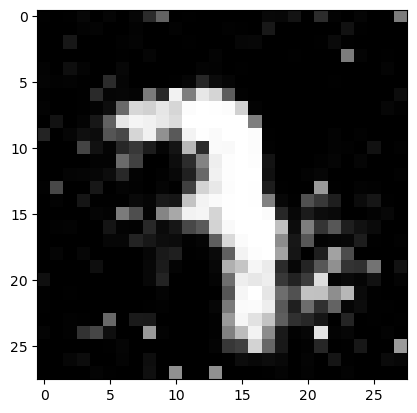

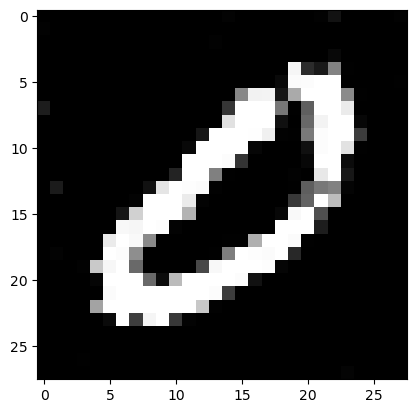

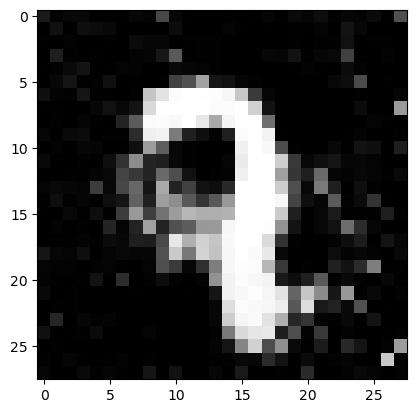

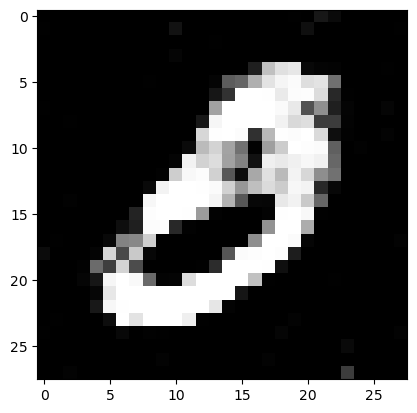

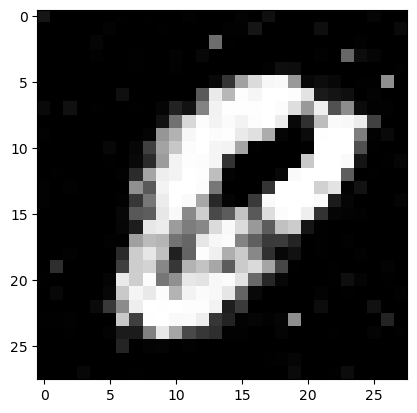

In [10]:
def generate_images(num_images=5):
    noise = np.random.normal(0, 1, (num_images, latent_dim))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5

    for i in range(num_images):
        plt.imshow(gen_imgs[i, :, :, 0], cmap='gray')
        plt.show()

# Generate new images
generate_images(5)